### LSTM MODEL - Error prediction fr next 5 days

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
df = pd.read_csv('train.csv')
df['date'] = pd.to_datetime(df['date'])
# Rename target column
df.rename(columns={'error_next_5_periods': 'error_t'}, inplace=True)
# Sort by date and set as index
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)
# Create lag features
for lag in (1, 2, 3):
    df[f'lag_{lag}'] = df['error_t'].shift(lag)
# Drop NaNs
df.dropna(inplace=True)

# Preview train data after lag features
print("Train DataFrame with date index and lag features (first 5 rows):")
print(df[['error_t', 'lag_1', 'lag_2', 'lag_3']].head())

# Define features and target
X = df[['lag_1', 'lag_2', 'lag_3']].values
y = df['error_t'].values.reshape(-1, 1)

# -----------------------------------------------------------------------------
# 2) Train/Validation Split
# -----------------------------------------------------------------------------
split = int(0.8 * len(X))
X_train_raw, X_val_raw = X[:split], X[split:]
y_train_raw, y_val_raw = y[:split], y[split:]


Train DataFrame with date index and lag features (first 5 rows):
             error_t     lag_1     lag_2     lag_3
date                                              
2020-02-04  0.993750  1.043390  1.057119  1.021202
2020-02-05  0.970497  0.993750  1.043390  1.057119
2020-02-06  0.961015  0.970497  0.993750  1.043390
2020-02-07  0.961128  0.961015  0.970497  0.993750
2020-02-10  0.964276  0.961128  0.961015  0.970497


In [ ]:
#scaling train dataset

In [2]:
scaler_X = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

X_tr_scaled = scaler_X.transform(X_train_raw)
X_val_scaled = scaler_X.transform(X_val_raw)
y_tr_scaled = scaler_y.transform(y_train_raw)
y_val_scaled = scaler_y.transform(y_val_raw)

# Preview scaled train inputs and targets
print("Scaled X_train (first 5 rows):")
print(pd.DataFrame(X_tr_scaled, columns=['lag_1', 'lag_2', 'lag_3'], index=df.index[:len(X_tr_scaled)]).head())
print("Scaled y_train (first 5 values):")
print(pd.DataFrame(y_tr_scaled, columns=['error_t_scaled'], index=df.index[:len(y_tr_scaled)]).head())


Scaled X_train (first 5 rows):
               lag_1     lag_2     lag_3
date                                    
2020-02-04  0.946440  1.204656  0.521119
2020-02-05  0.002391  0.943818  1.203428
2020-02-06 -0.439843  0.000701  0.942627
2020-02-07 -0.620172 -0.441097 -0.000360
2020-02-10 -0.618019 -0.621248 -0.442095
Scaled y_train (first 5 values):
            error_t_scaled
date                      
2020-02-04        0.002923
2020-02-05       -0.439488
2020-02-06       -0.619889
2020-02-07       -0.617735
2020-02-10       -0.557843


In [ ]:
#reshaping

In [3]:
X_tr = X_tr_scaled.reshape((X_tr_scaled.shape[0], X_tr_scaled.shape[1], 1))
X_val = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
y_tr = y_tr_scaled.flatten()
y_val = y_val_scaled.flatten()


In [ ]:
#LSTM model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the deep LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_tr.shape[1], 1), dropout=0.2, recurrent_dropout=0.1),
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


C:\Users\Lenova\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - loss: 1.0139 - val_loss: 0.7485
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9681 - val_loss: 0.7078
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9263 - val_loss: 0.6571
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8755 - val_loss: 0.5876
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8138 - val_loss: 0.5049
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5907 - val_loss: 0.4184
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5576 - val_loss: 0.3362
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5619 - val_loss: 0.2922
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4428 - val_loss: 0.2789
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4309 - val_loss: 0.2700
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4767 - val_loss: 0.2732
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/ste

In [54]:
# -----------------------------------------------------------------------------
# 6) Evaluate on TRAIN+VAL
# -----------------------------------------------------------------------------
Xs_full = np.concatenate([X_train_raw, X_val_raw])
ys_full = np.concatenate([y_train_raw, y_val_raw])
Xs_full_scaled = scaler_X.transform(Xs_full).reshape((len(Xs_full), 3, 1))

train_pred_scaled = model.predict(Xs_full_scaled).flatten()
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


In [55]:
# -----------------------------------------------------------------------------
# 7) TEST Data: Load, rename target, set index & create lag features
# -----------------------------------------------------------------------------
test_df = pd.read_csv('test.csv')
test_df['date'] = pd.to_datetime(test_df['date'])
test_df.rename(columns={'error_next_5_periods': 'error_t'}, inplace=True)
test_df.sort_values('date', inplace=True)
test_df.set_index('date', inplace=True)
for lag in (1, 2, 3):
    test_df[f'lag_{lag}'] = test_df['error_t'].shift(lag)
    
# Drop NaNs
test_df.dropna(inplace=True)

# Preview test data after lag features
print("Test DataFrame with date index and lag features (first 5 rows):")
print(test_df[['error_t', 'lag_1', 'lag_2', 'lag_3']].head())


Test DataFrame with date index and lag features (first 5 rows):
             error_t     lag_1     lag_2     lag_3
date                                              
2023-10-05  0.979620  0.998712  1.022286  1.033465
2023-10-06  0.957932  0.979620  0.998712  1.022286
2023-10-09  0.944234  0.957932  0.979620  0.998712
2023-10-10  0.935094  0.944234  0.957932  0.979620
2023-10-11  0.936530  0.935094  0.944234  0.957932


In [56]:
# Define test features and target
X_test_raw = test_df[['lag_1', 'lag_2', 'lag_3']].values
y_test_raw = test_df['error_t'].values.reshape(-1, 1)

# -----------------------------------------------------------------------------
# 8) Scaling TEST Data
# -----------------------------------------------------------------------------
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

# Preview scaled test inputs and targets
print("Scaled X_test (first 5 rows):")
print(pd.DataFrame(X_test_scaled, columns=['lag_1', 'lag_2', 'lag_3'], index=test_df.index[:len(X_test_scaled)]).head())
print("Scaled y_test (first 5 values):")
print(pd.DataFrame(y_test_scaled, columns=['error_t_scaled'], index=test_df.index[:len(y_test_scaled)]).head())


Scaled X_test (first 5 rows):
               lag_1     lag_2     lag_3
date                                    
2023-10-05  0.096760  0.542849  0.754078
2023-10-06 -0.266337  0.094976  0.541713
2023-10-09 -0.678801 -0.267762  0.093903
2023-10-10 -0.939310 -0.679820 -0.268785
2023-10-11 -1.113123 -0.940071 -0.680785
Scaled y_test (first 5 values):
            error_t_scaled
date                      
2023-10-05       -0.265912
2023-10-06       -0.678542
2023-10-09       -0.939154
2023-10-10       -1.113036
2023-10-11       -1.085720


In [57]:
# Reshape for prediction
Xs_test = X_test_scaled.reshape((len(X_test_scaled), 3, 1))
# Predictions
test_pred_scaled = model.predict(Xs_test).flatten()
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -----------------------------------------------------------------------------
# Compute & display regression metrics for Train and Test
# -----------------------------------------------------------------------------
def print_regression_metrics(name, y_true, y_pred):
    mse   = mean_squared_error(y_true, y_pred)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(y_true, y_pred)
    r2    = r2_score(y_true, y_pred)
    print(f"--- {name} Metrics ---")
    print(f"MSE : {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    print(f"R²  : {r2:.6f}\n")

# Train metrics
print_regression_metrics("Train", df['error_t'].values, train_pred)

# Test metrics
print_regression_metrics("Test",  test_df['error_t'].values, test_pred)


--- Train Metrics ---
MSE : 0.000329
RMSE: 0.018126
MAE : 0.013170
R²  : 0.875171

--- Test Metrics ---
MSE : 0.000308
RMSE: 0.017561
MAE : 0.010887
R²  : 0.867904



### Traget Prediction Generator plot 

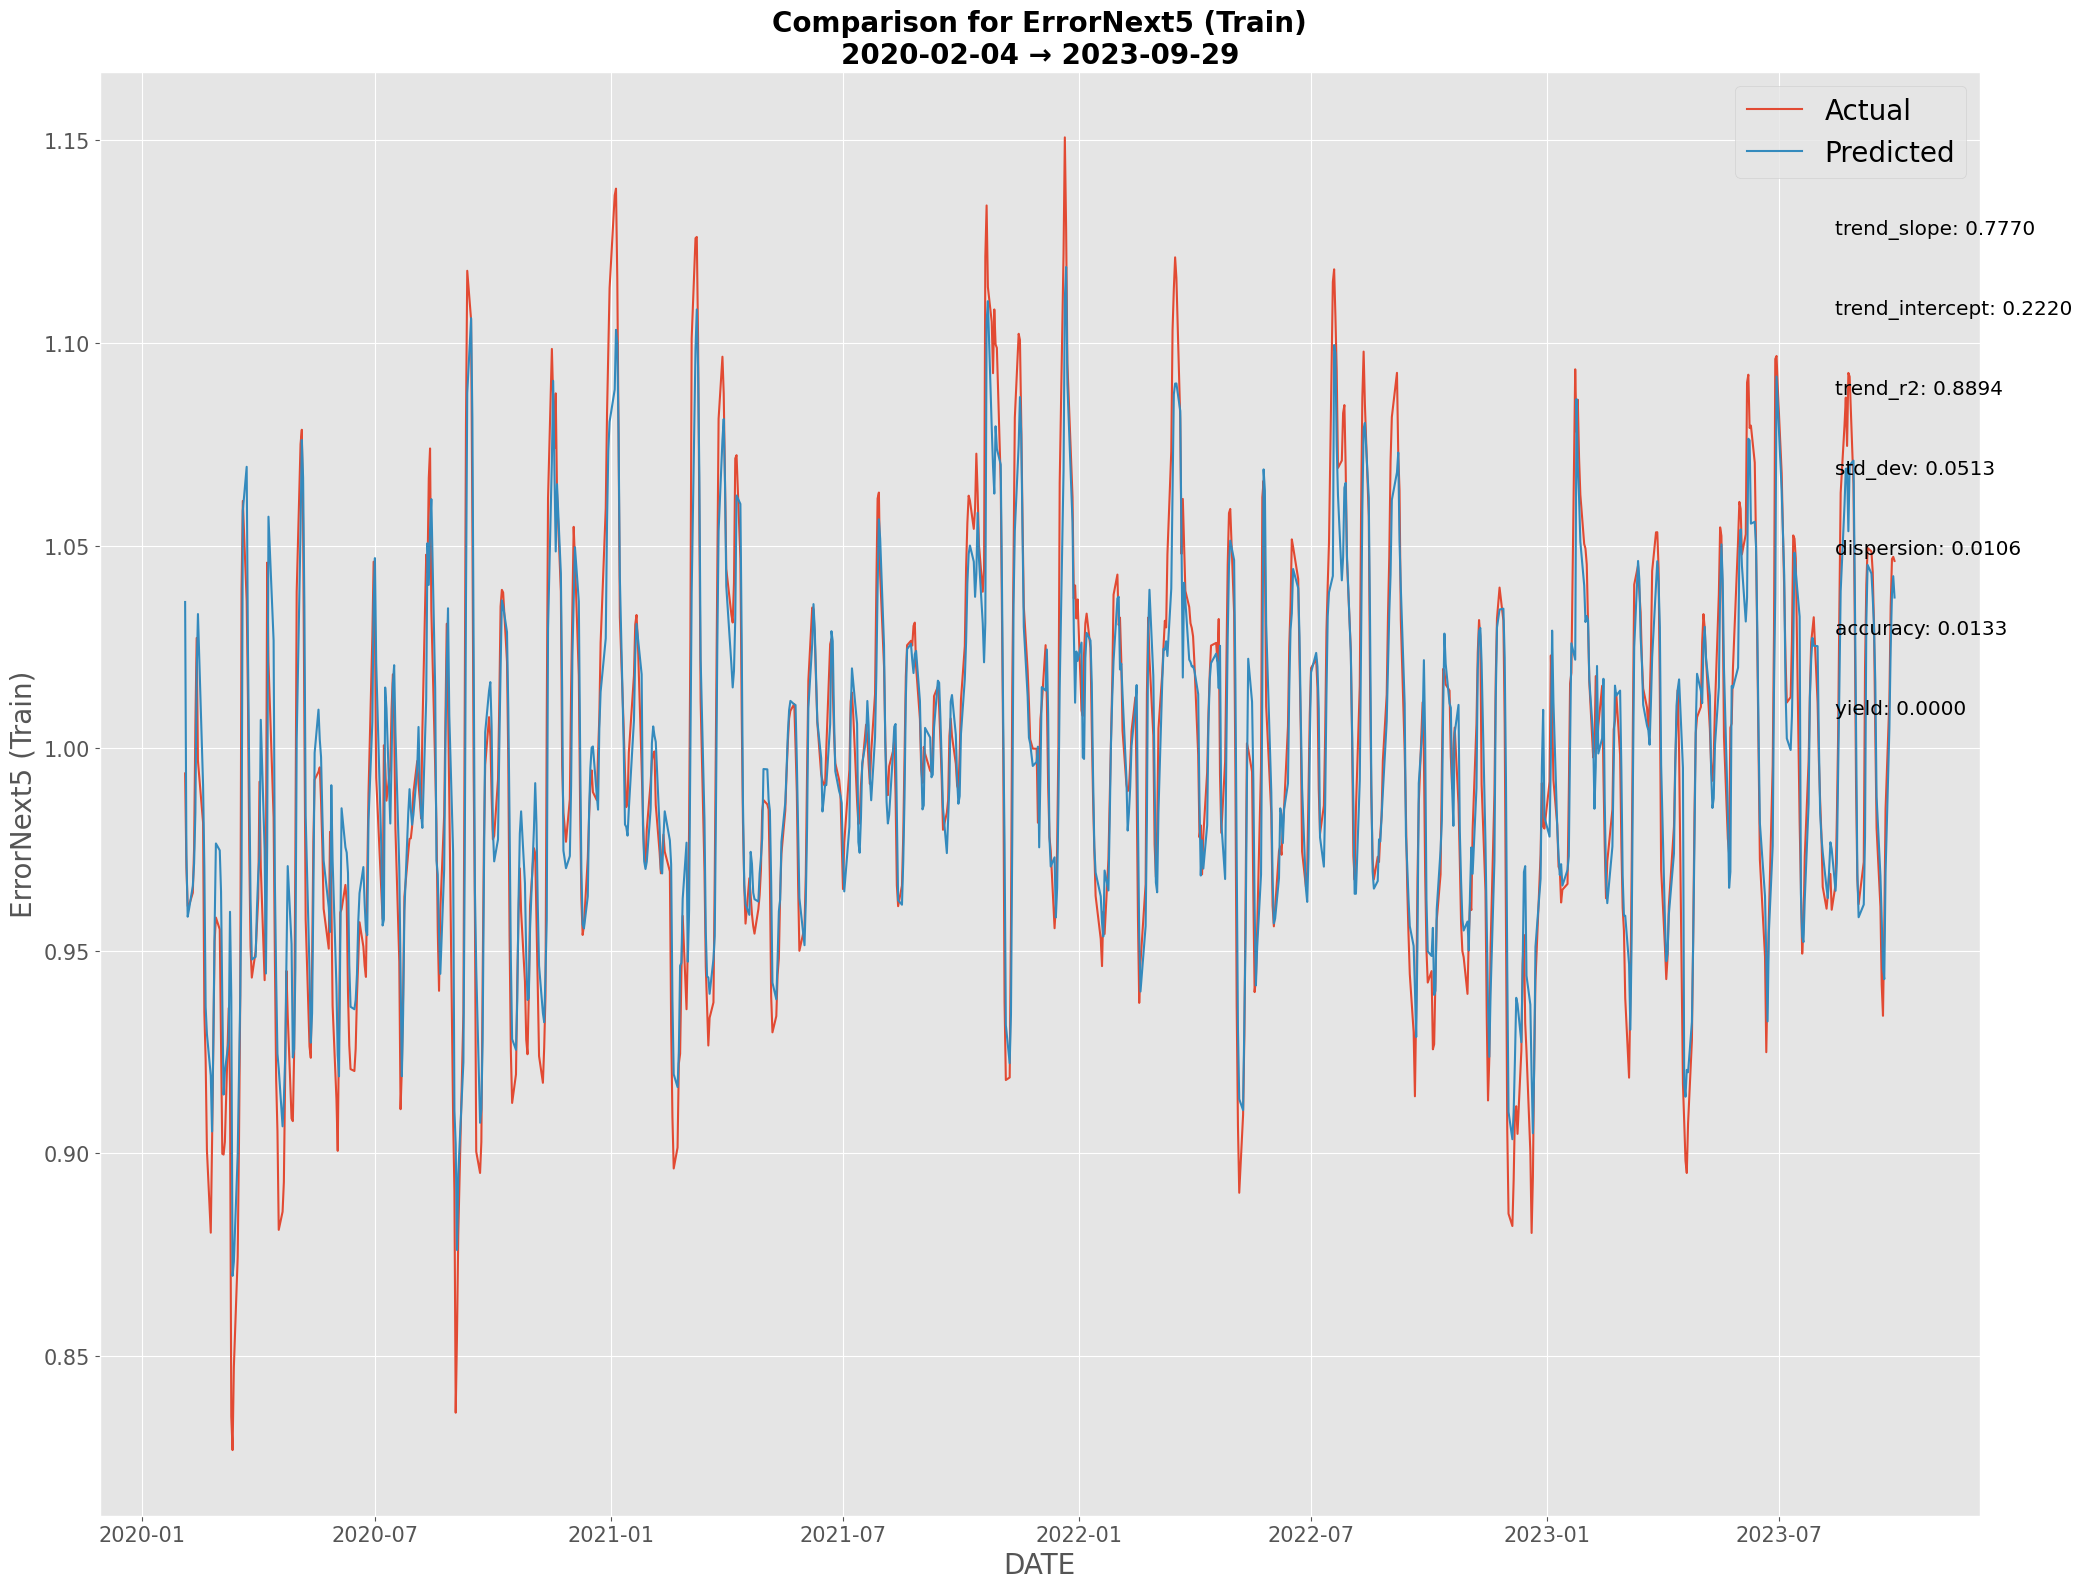

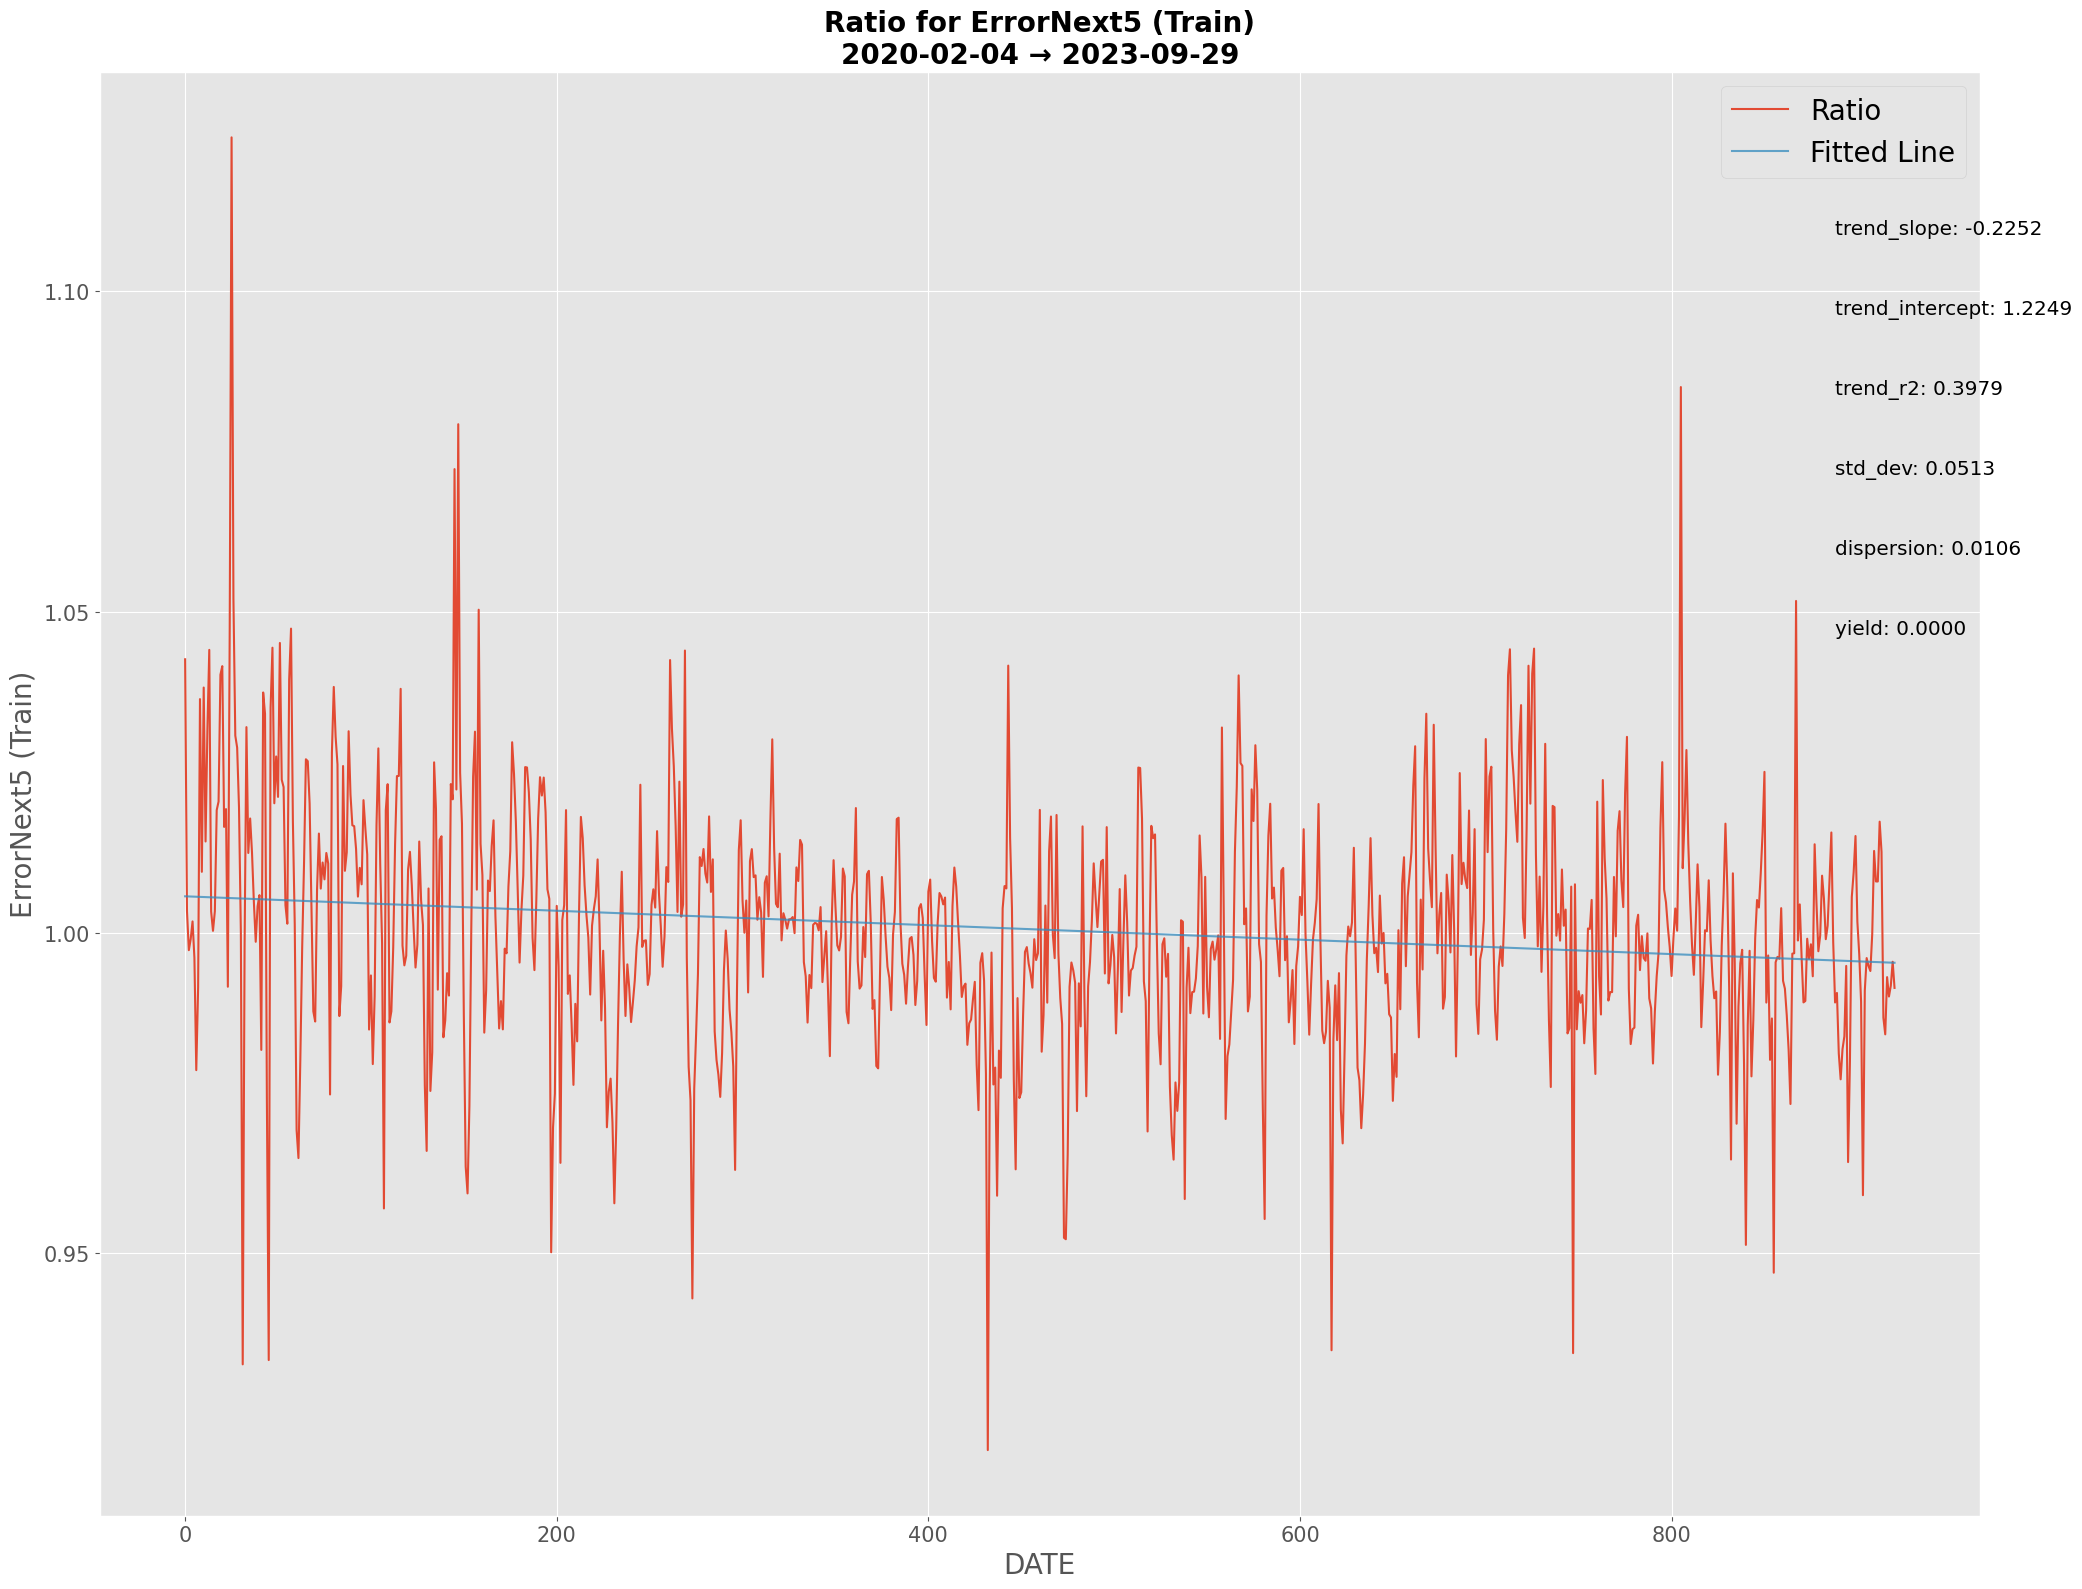

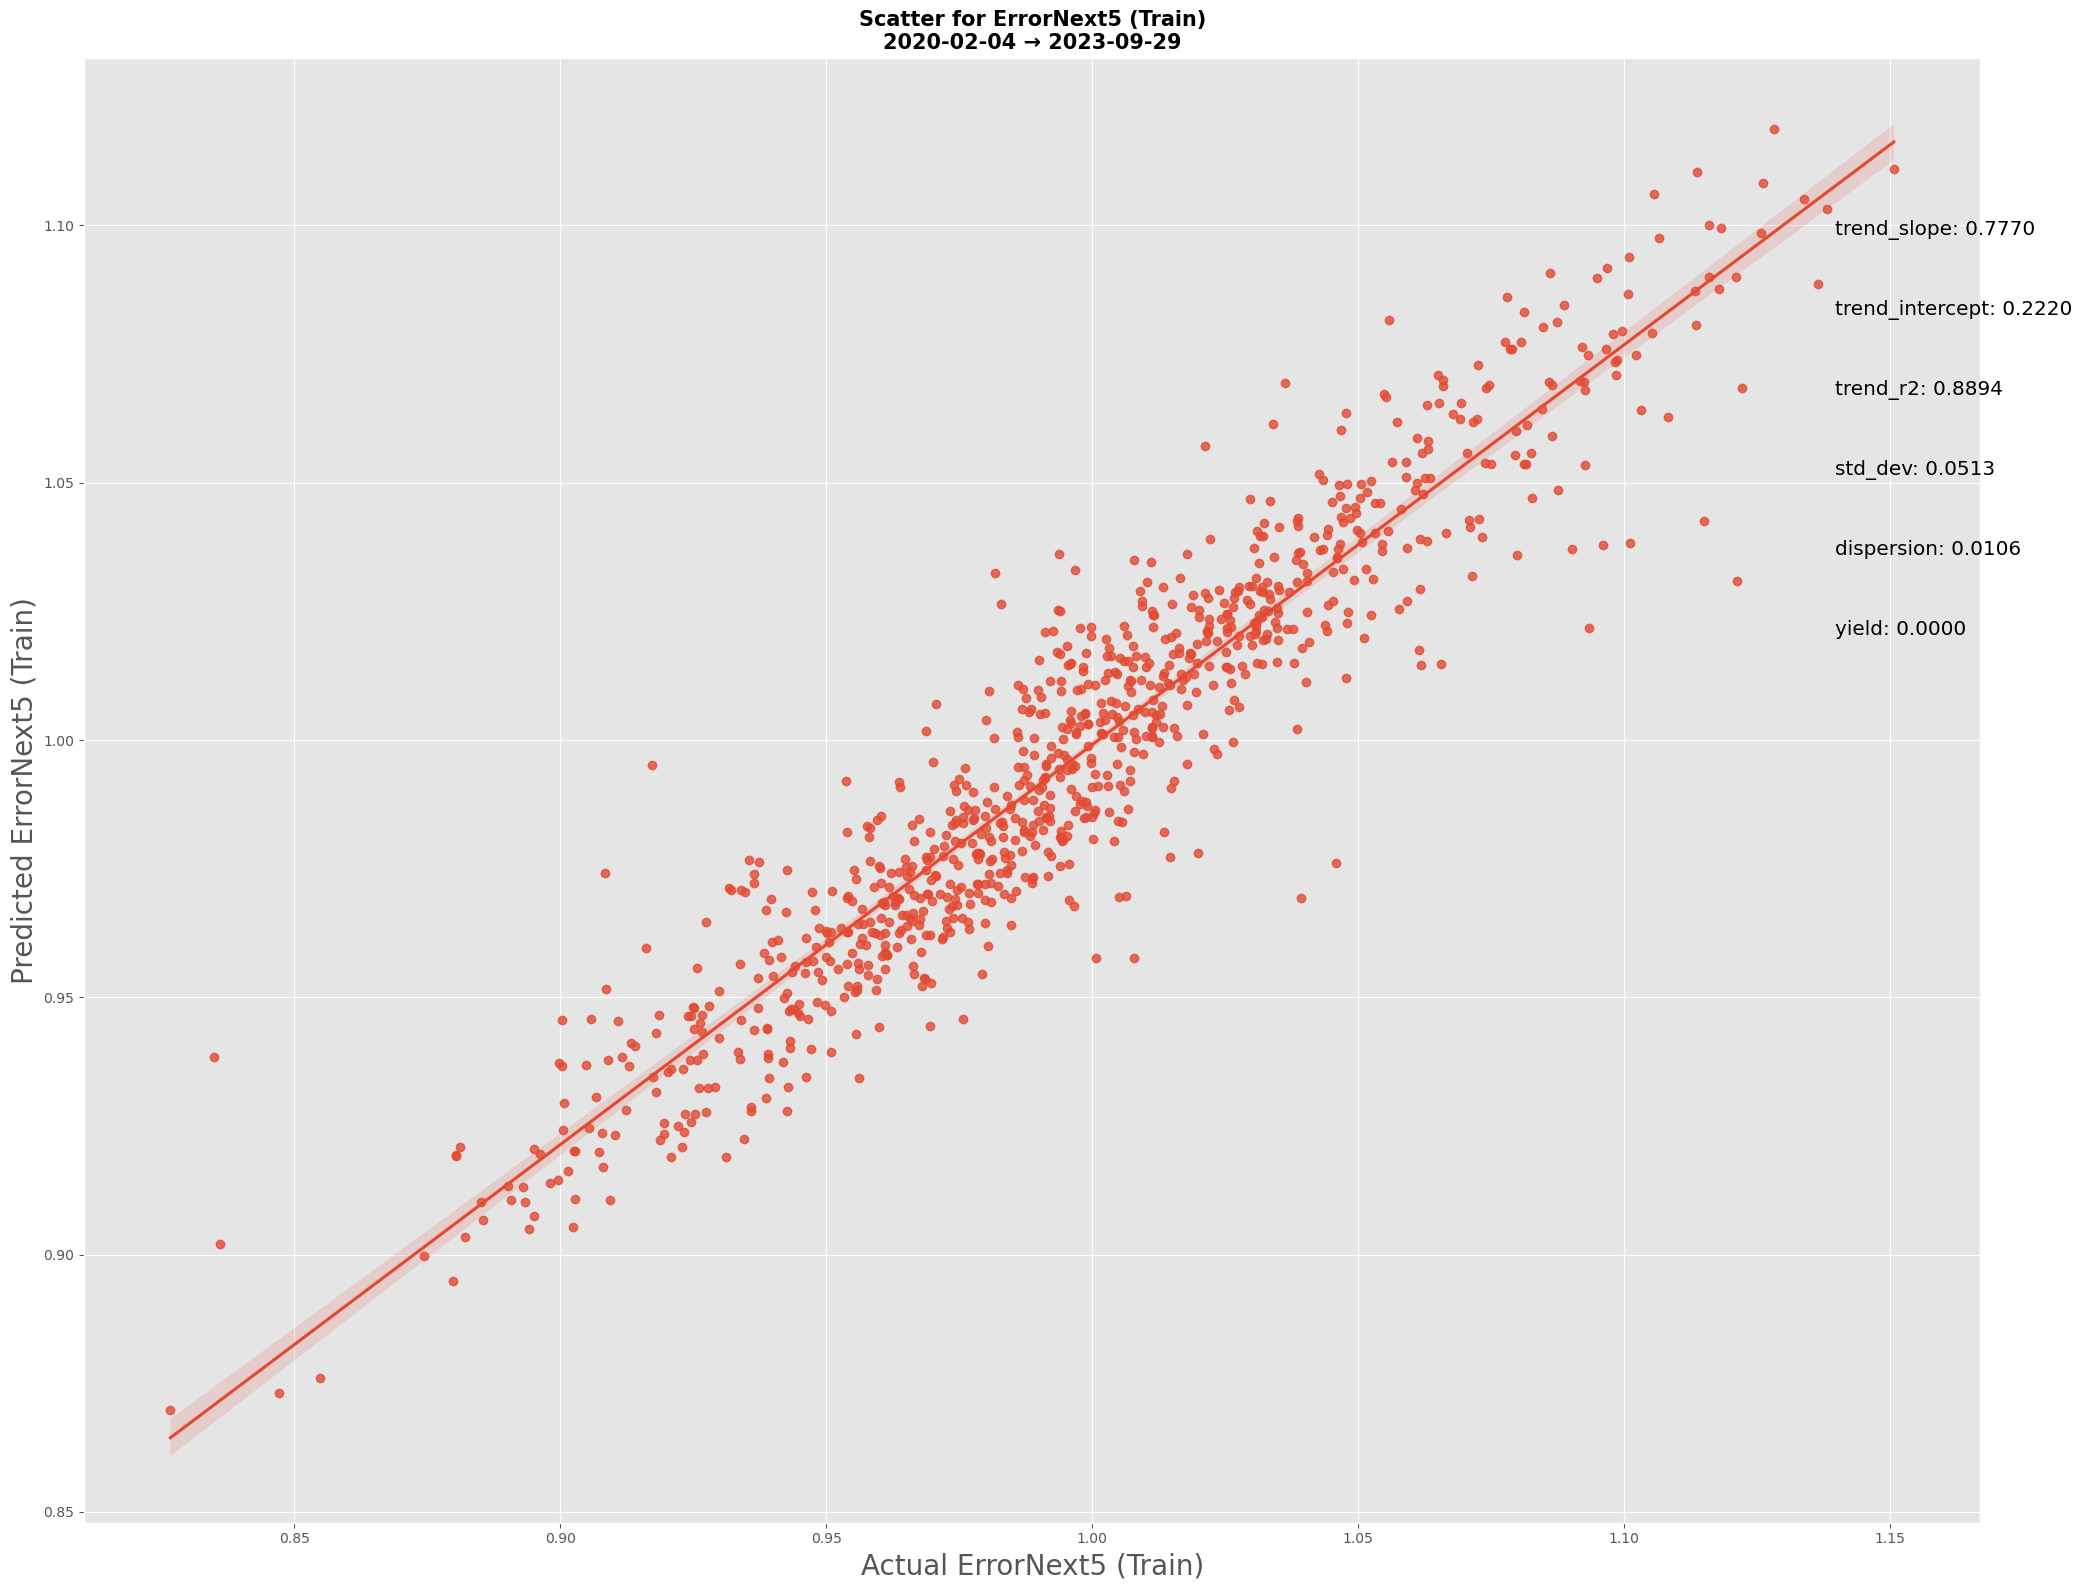

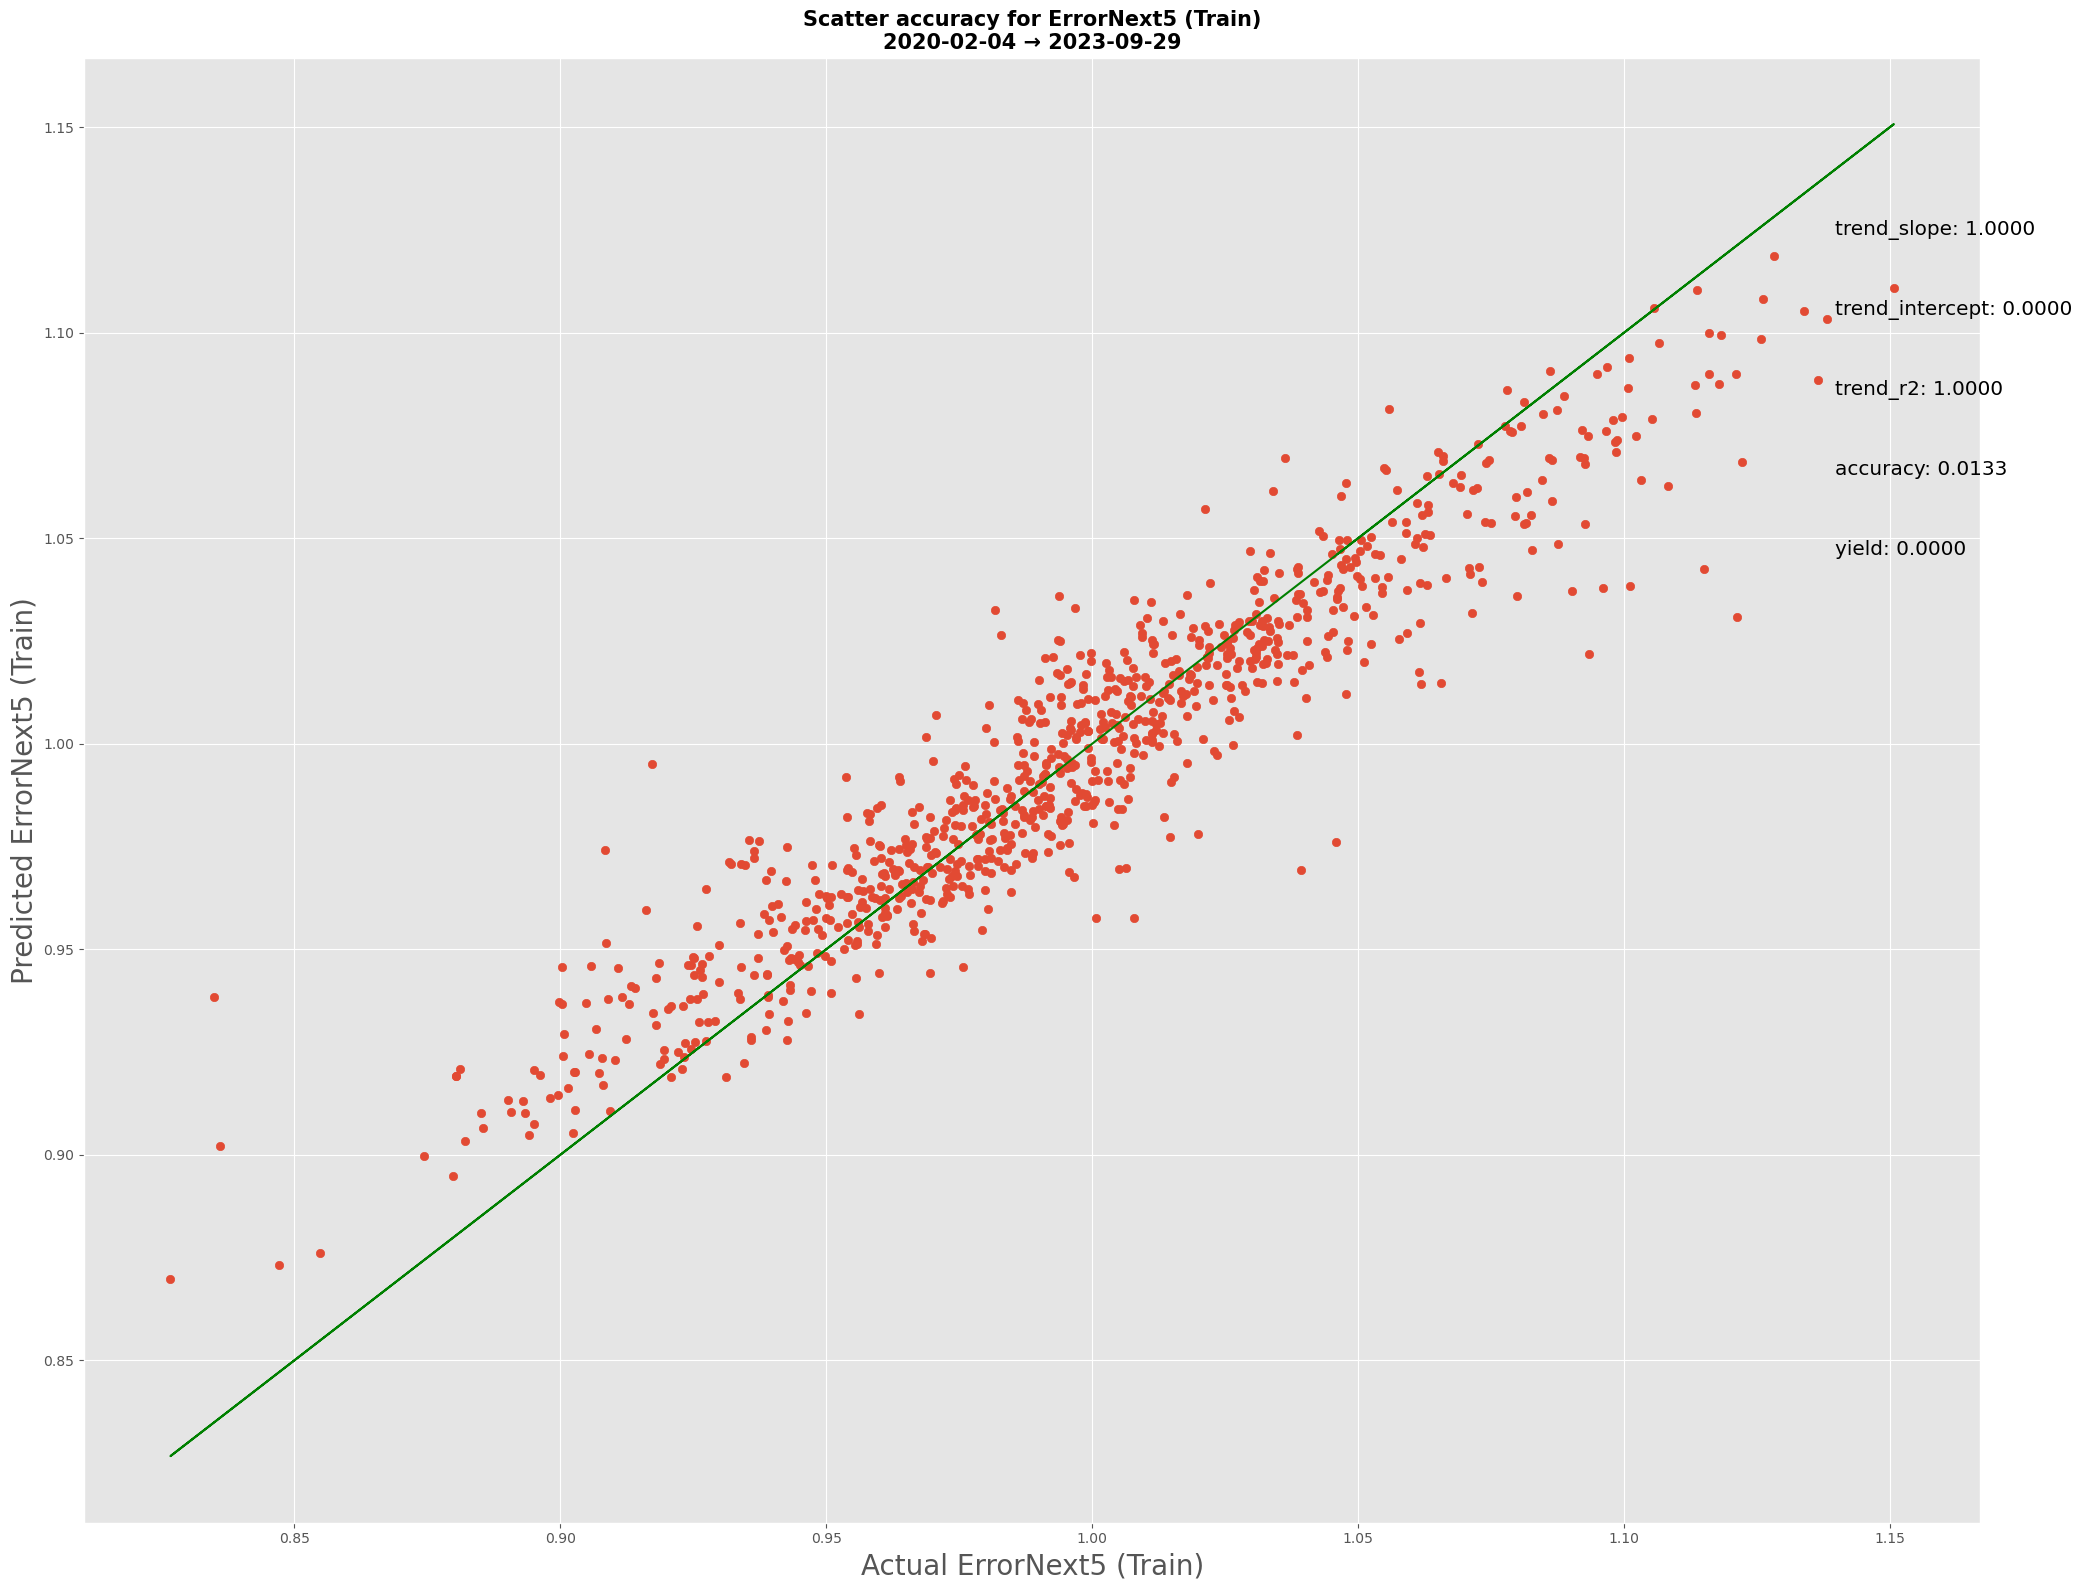

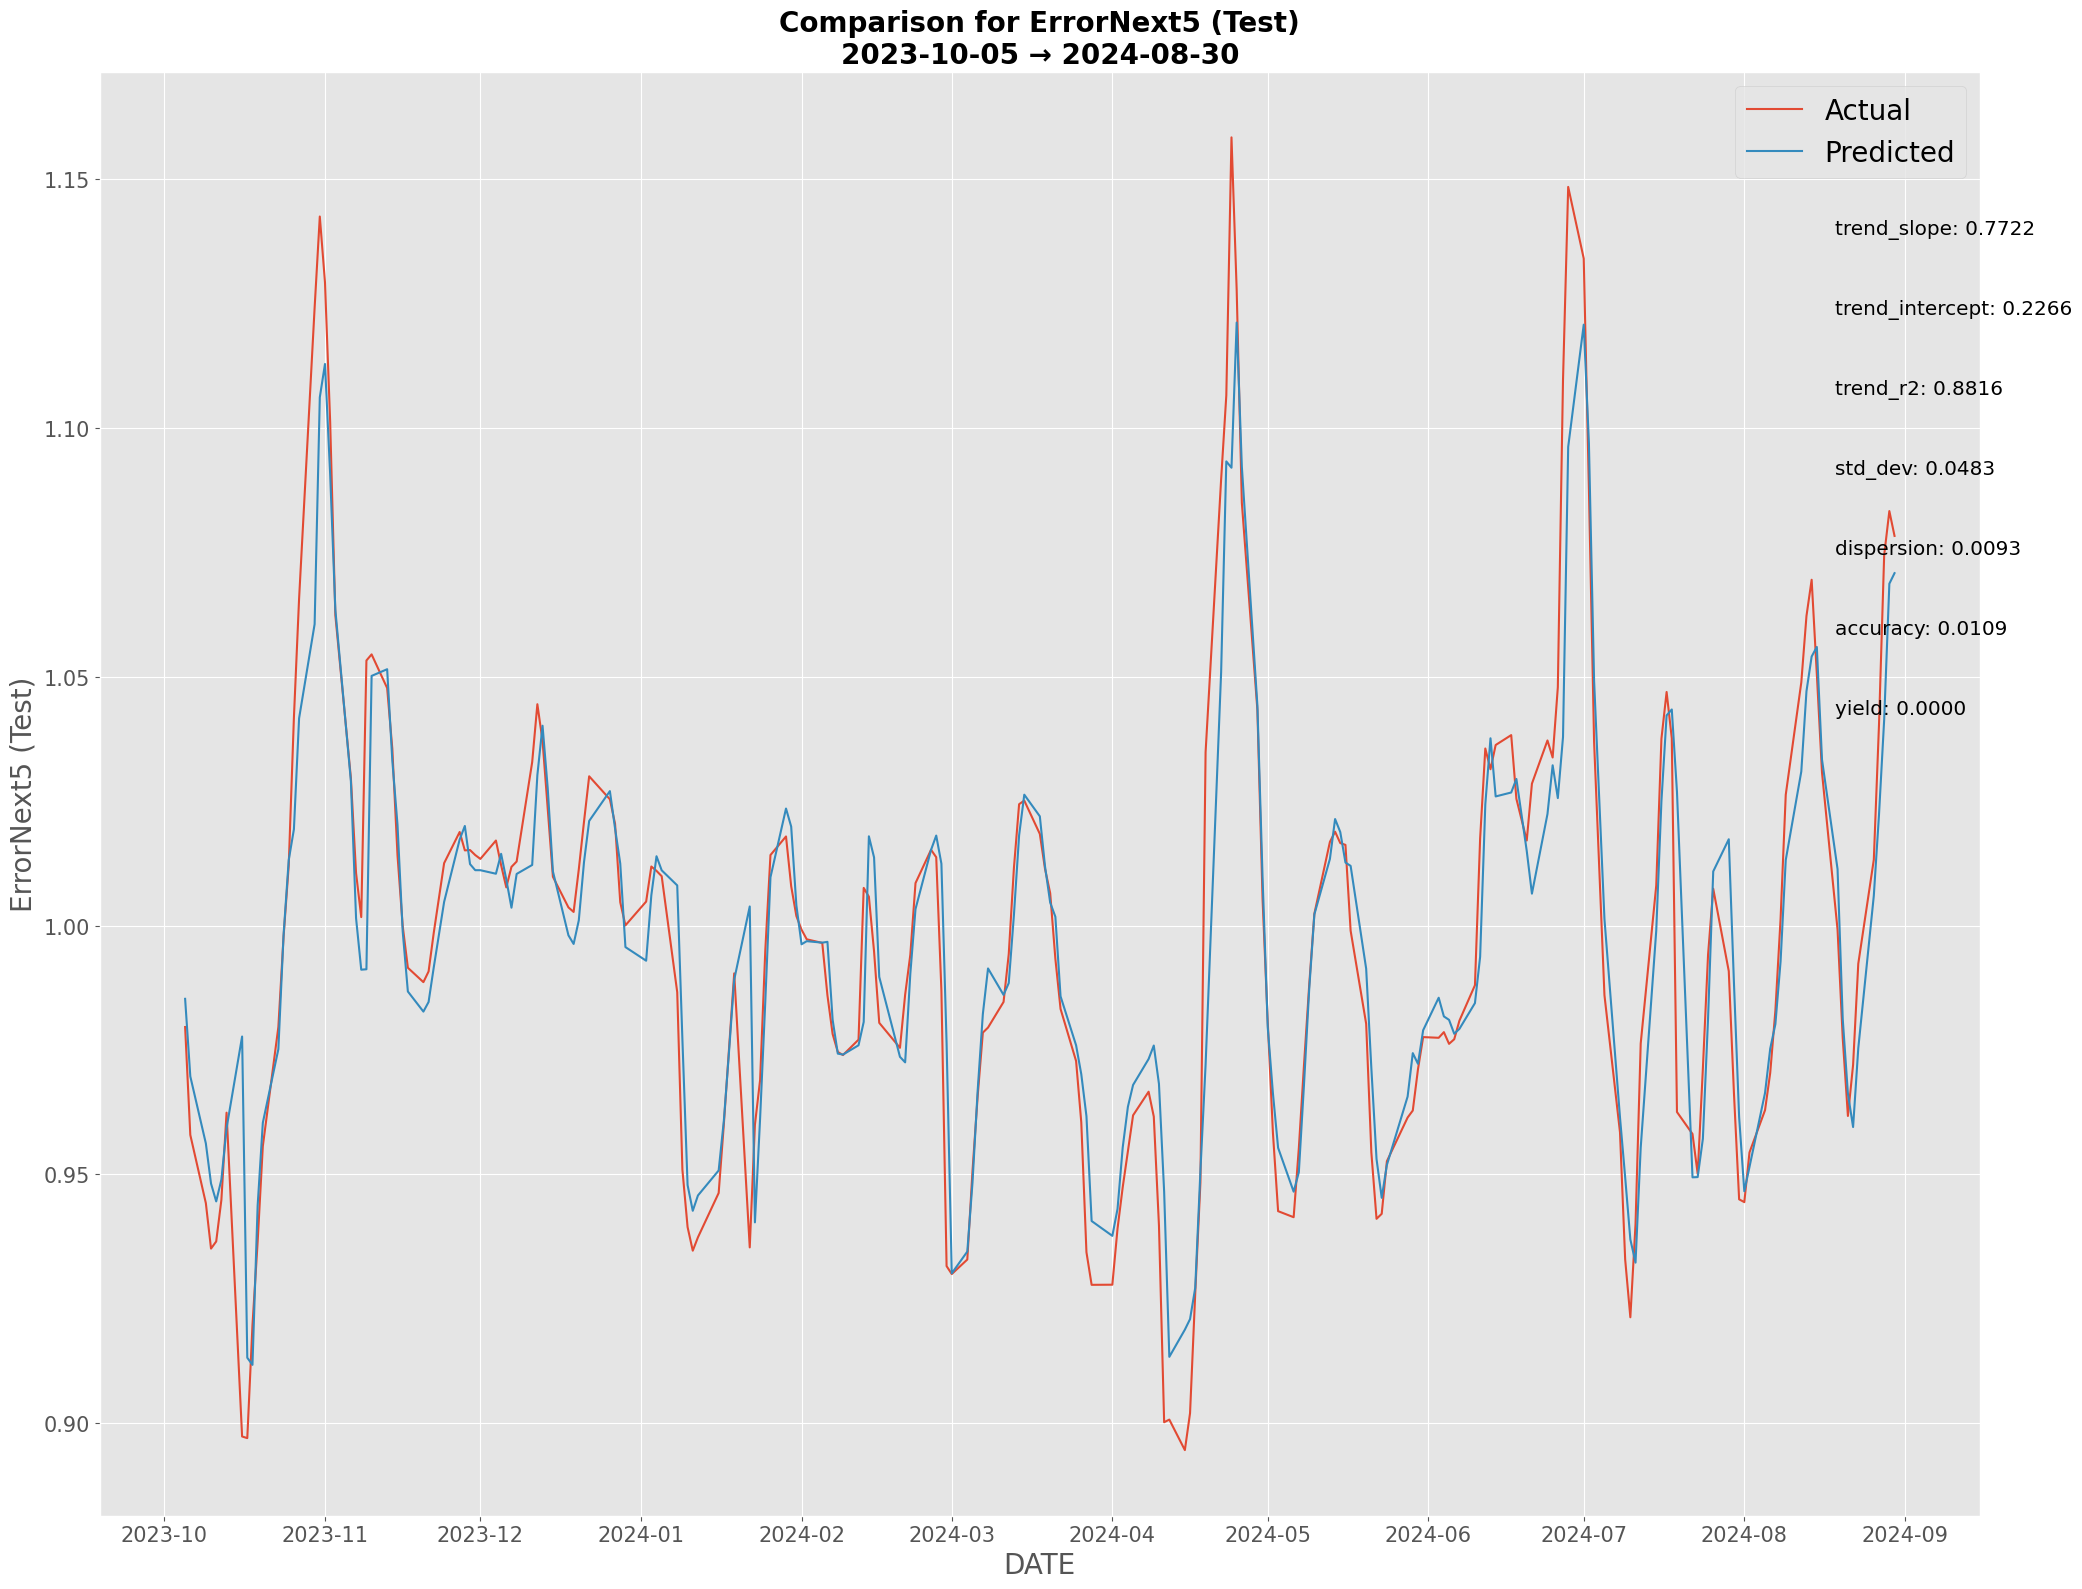

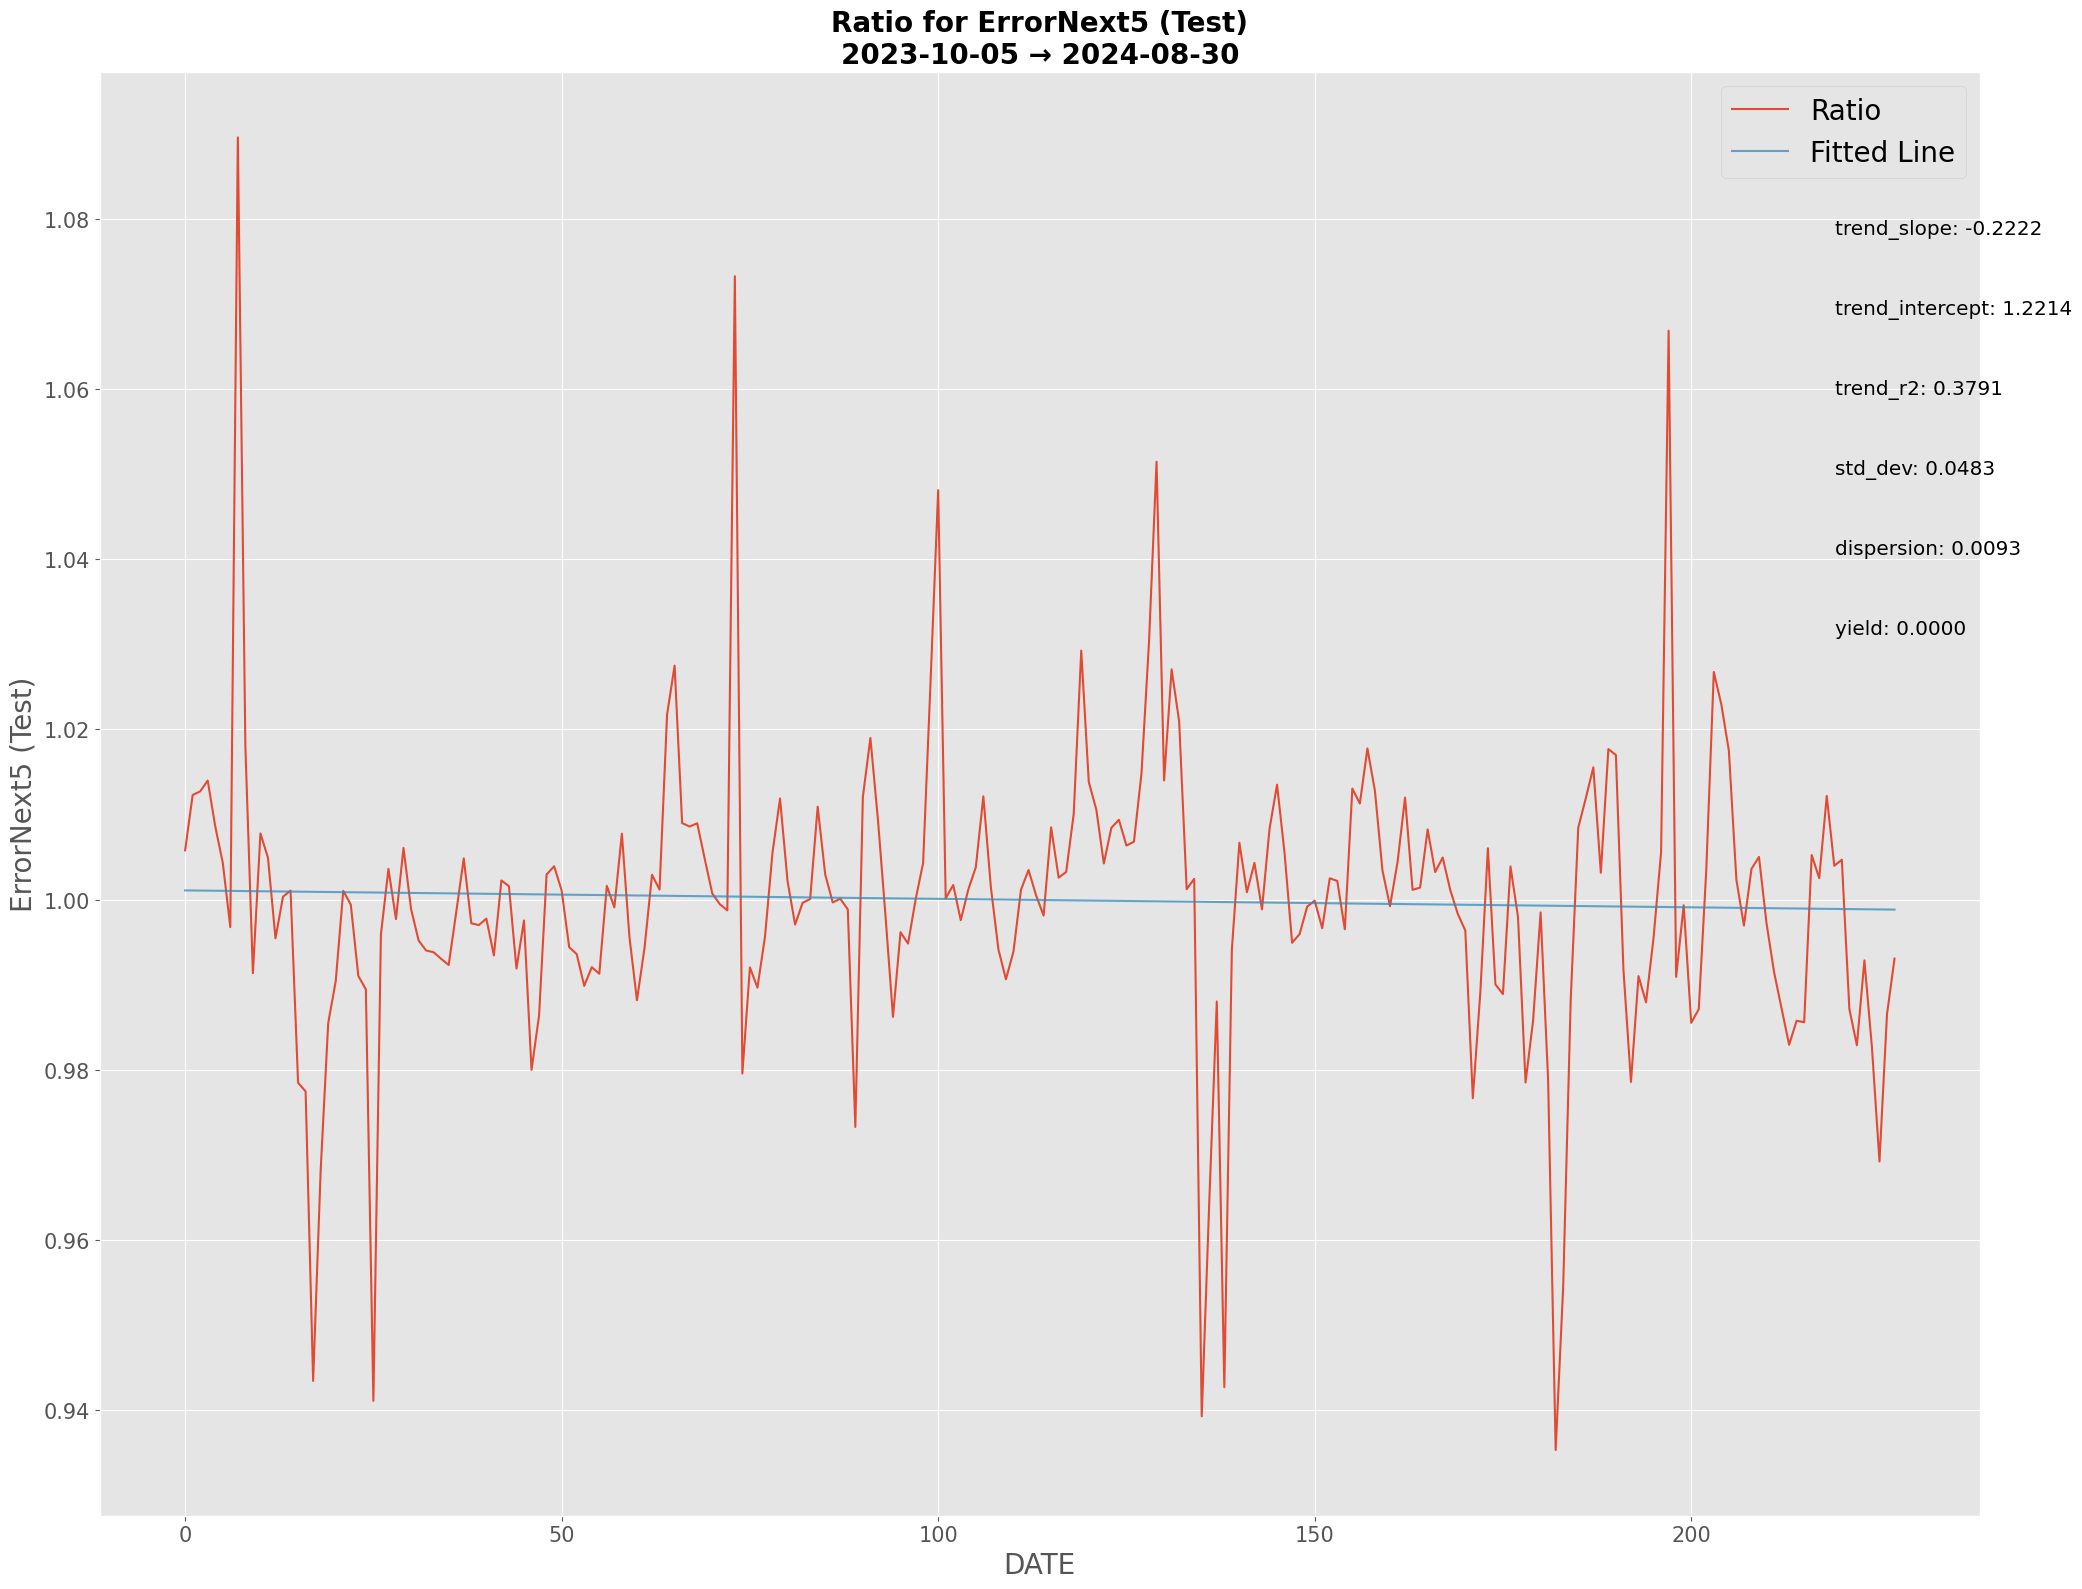

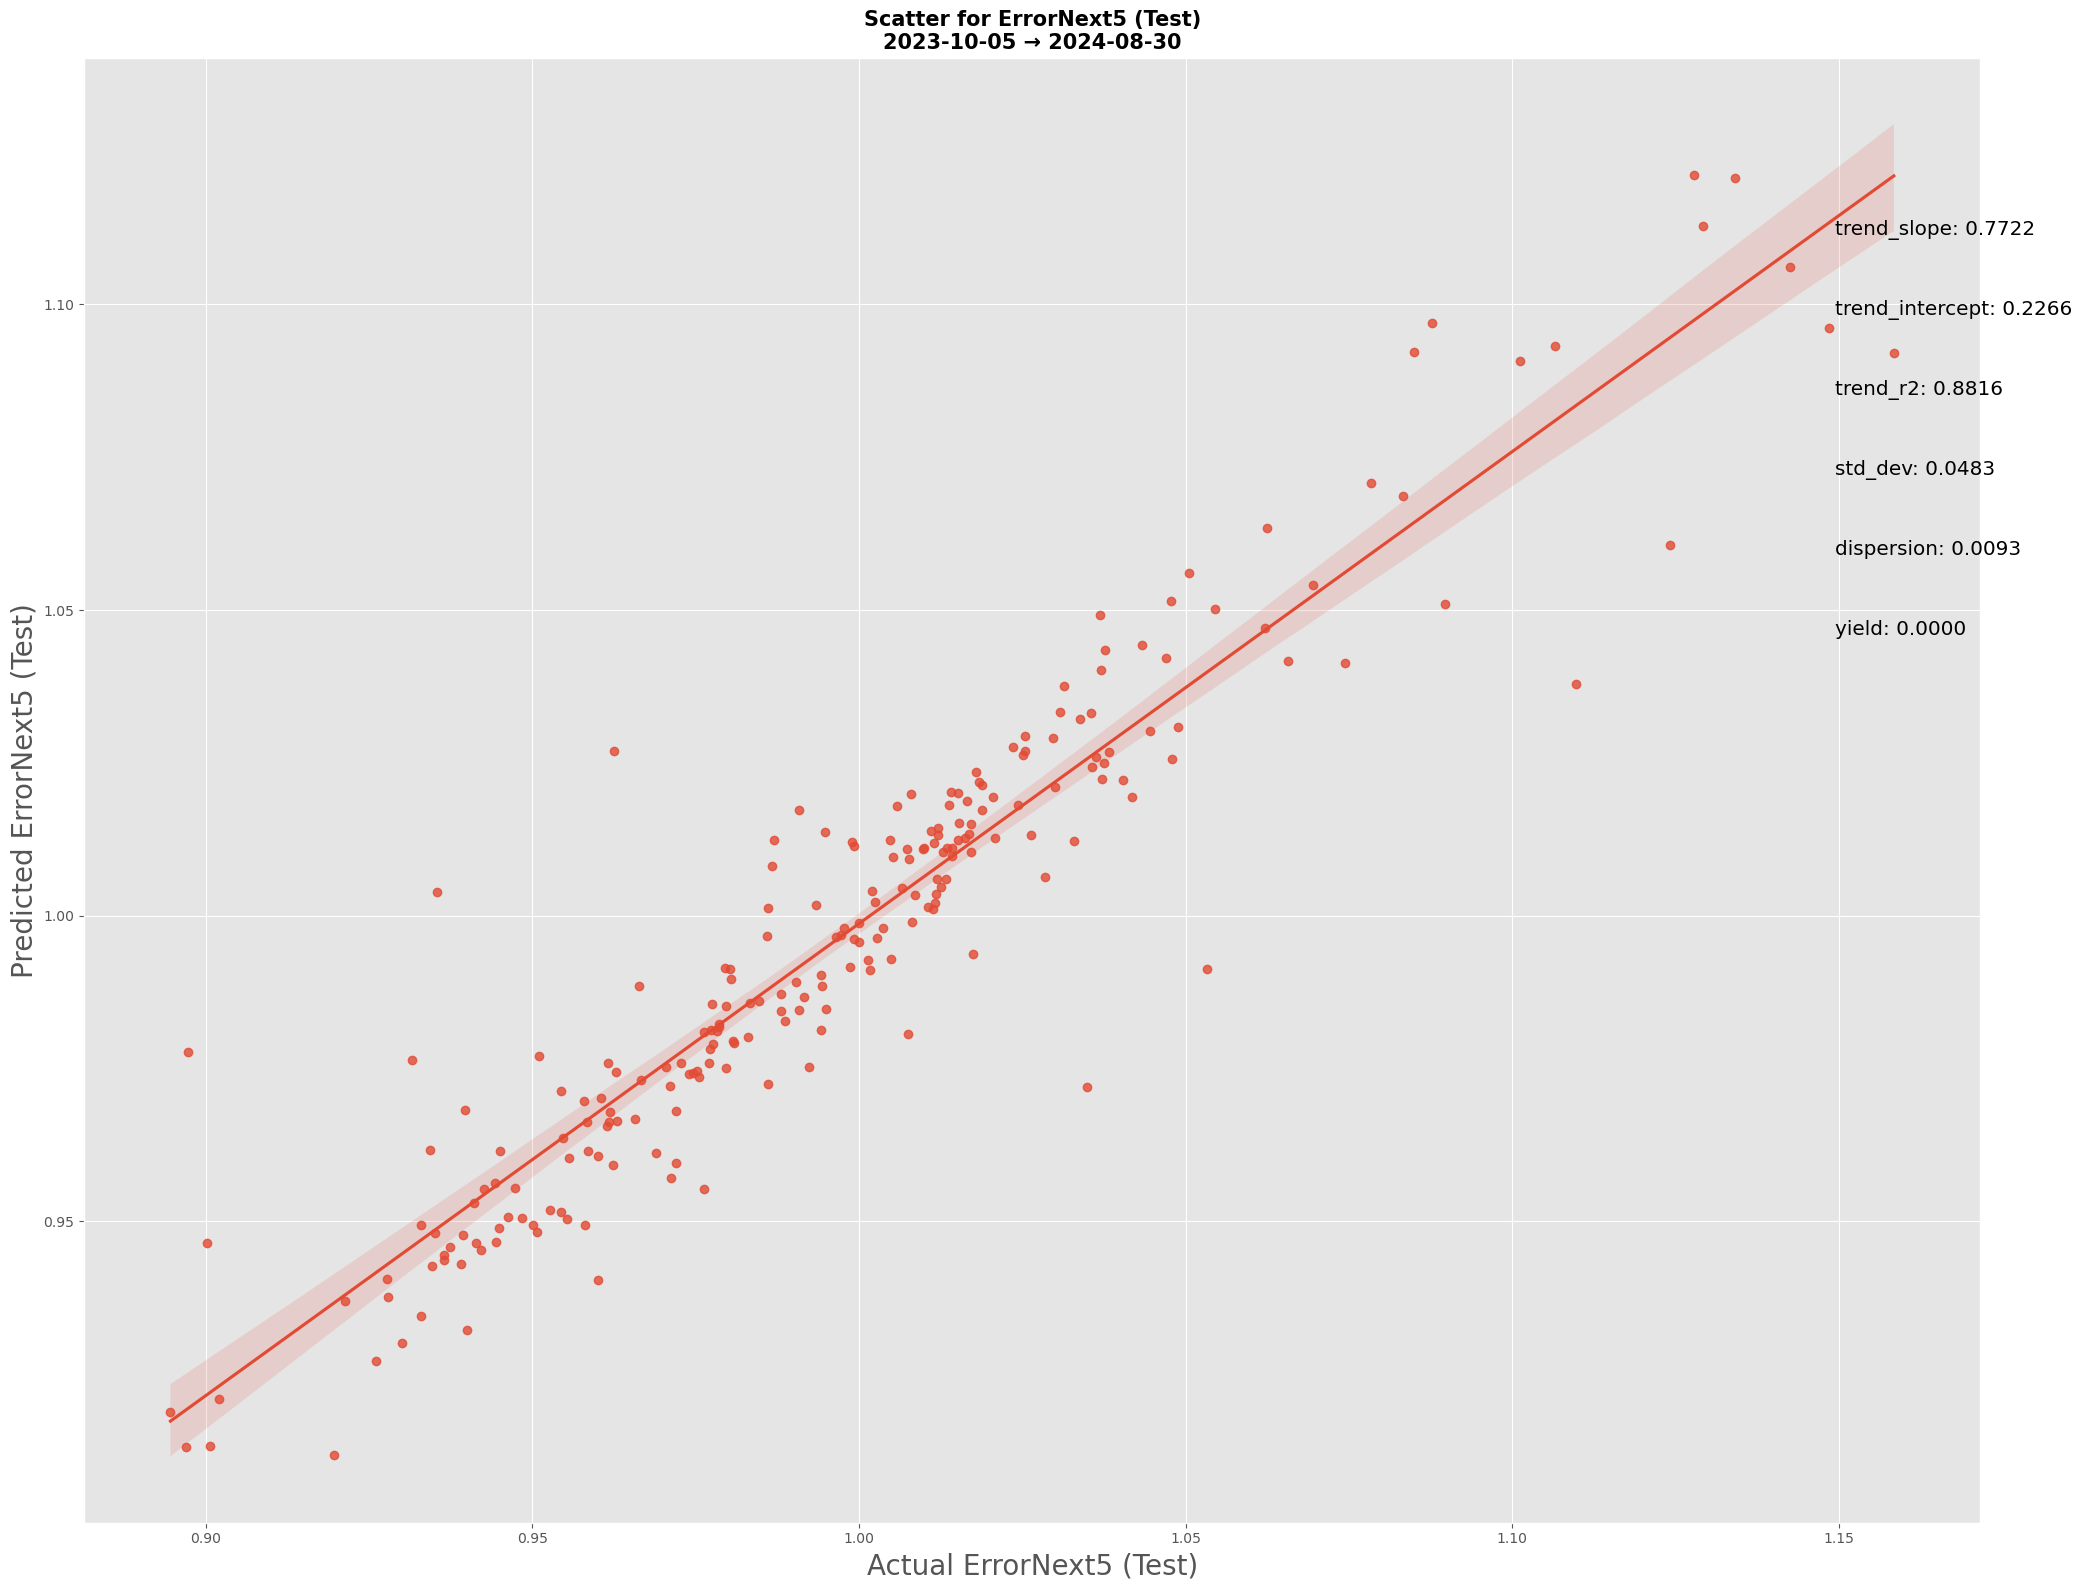

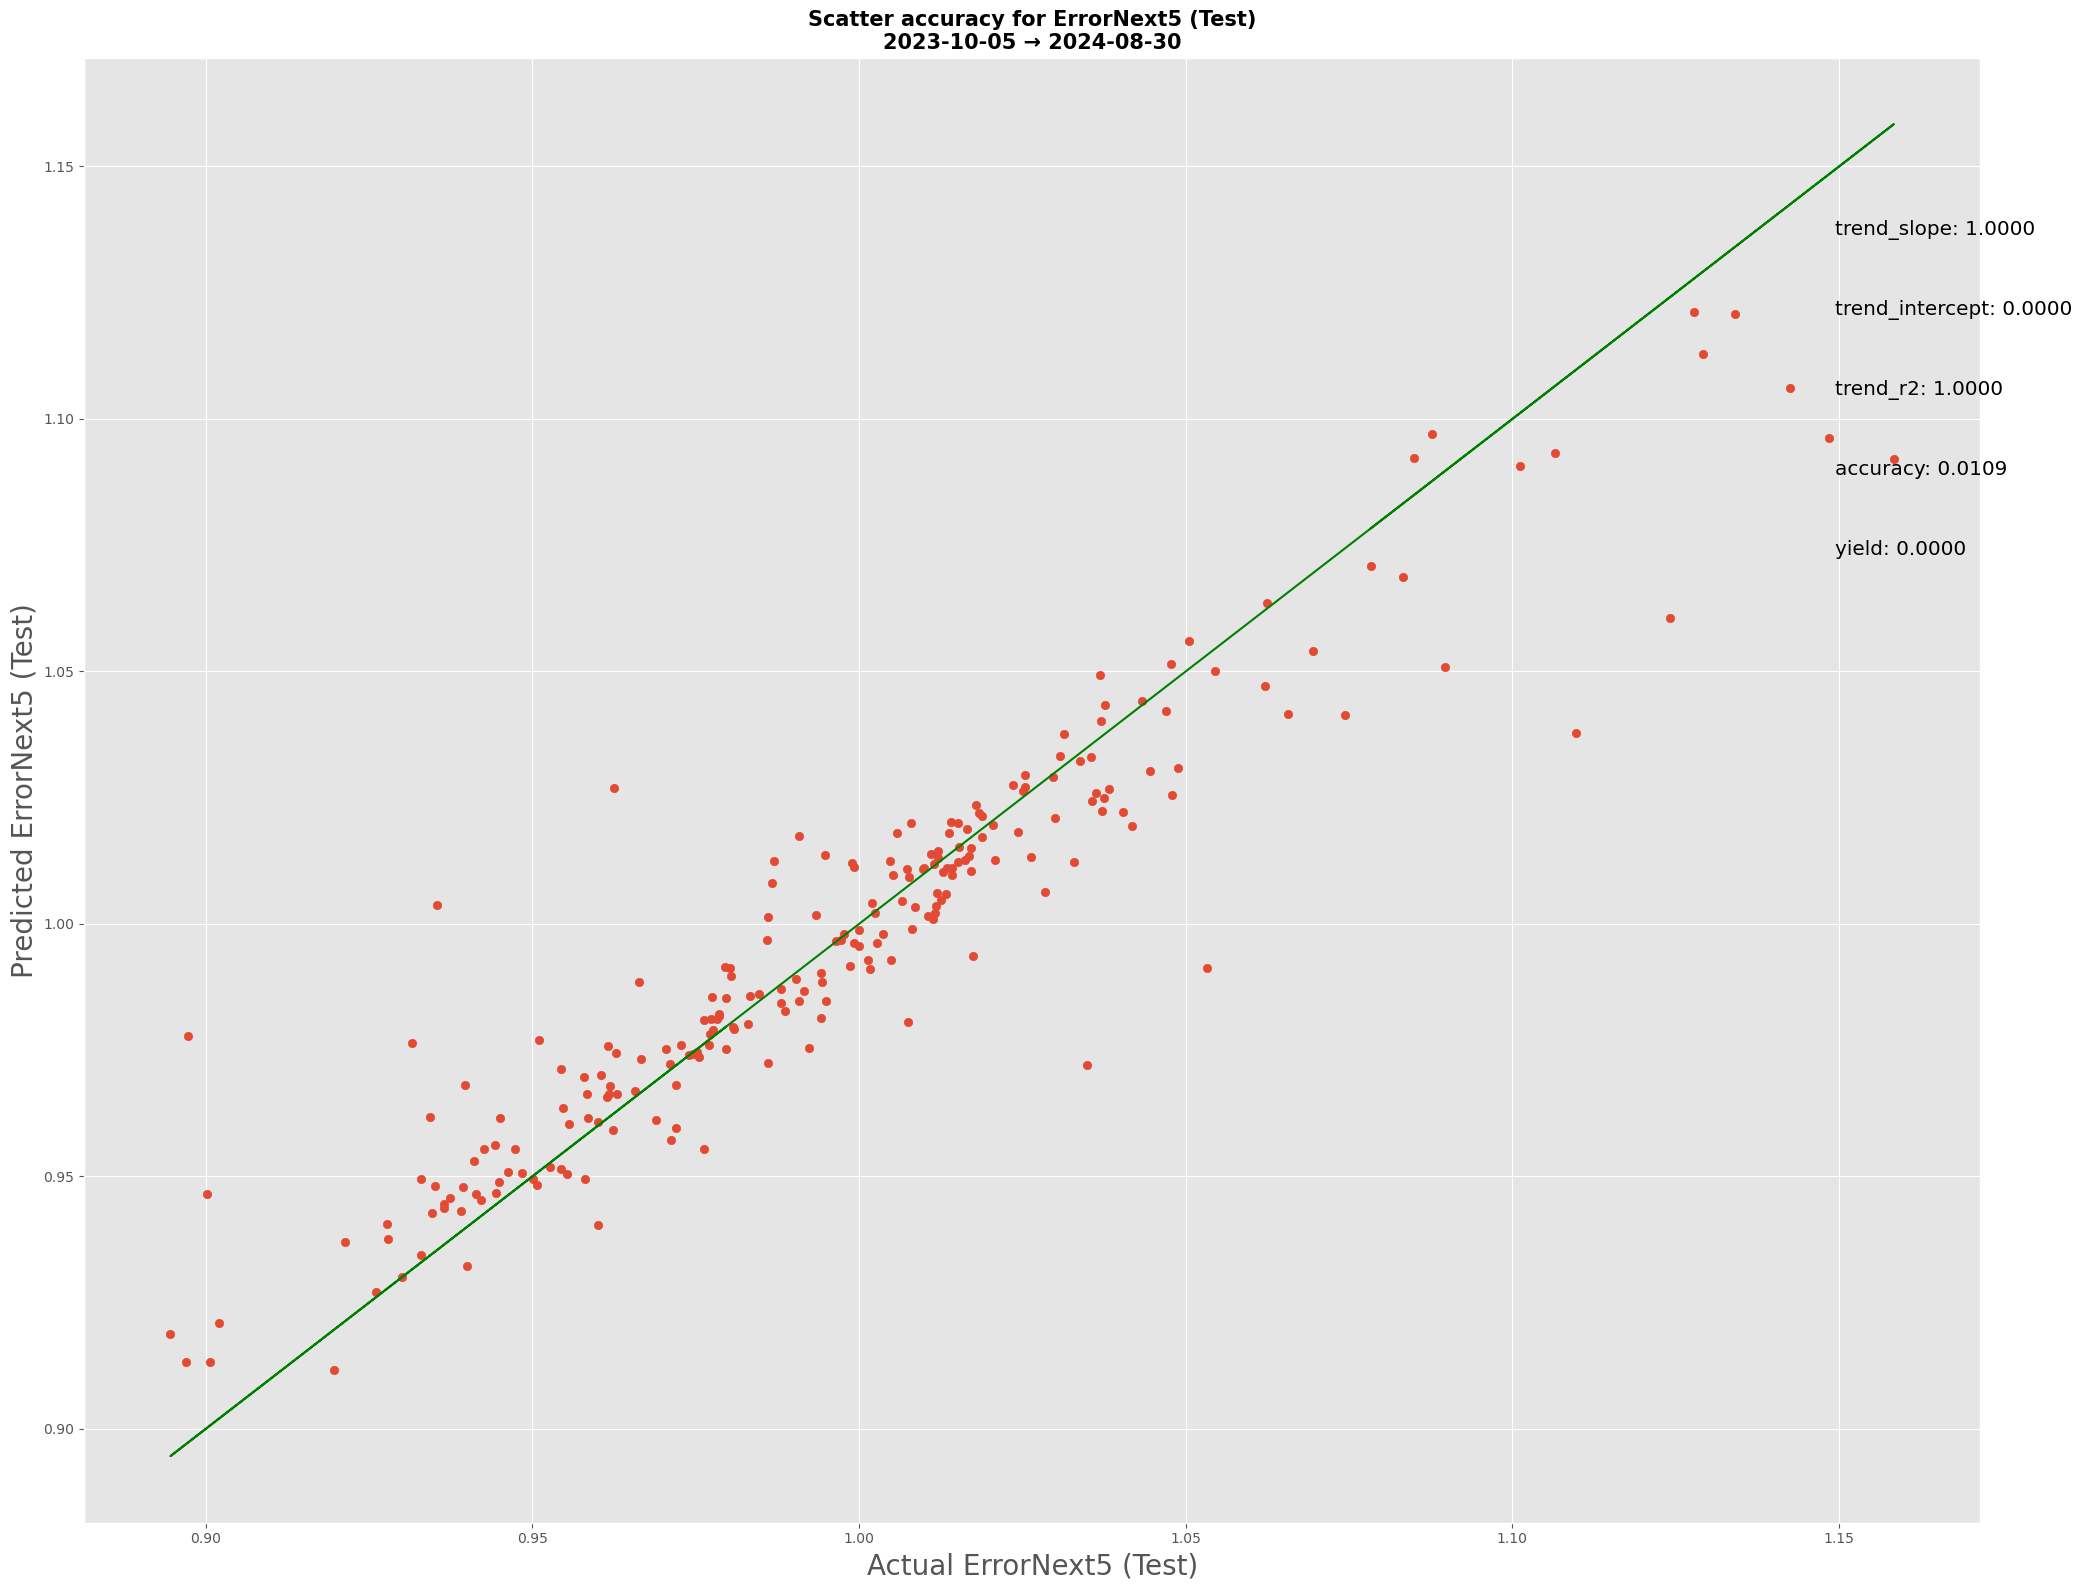

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from scipy.stats import linregress

plt.style.use('ggplot')

def sir_parameters(x, y):
    x = np.array(x); y = np.array(y)
    p = linregress(x, y)
    slope, intercept, rvalue = p.slope, p.intercept, p.rvalue
    y_trend_line = slope * x + intercept
    avg_tld = np.mean(np.abs(y_trend_line - y) / y_trend_line)
    accuracy = np.mean(np.abs(x - y) / x)
    return slope, intercept, rvalue**2, avg_tld, accuracy, x

def comparison_plot(predicted, actual, dates, target, yield_):
    slope, intercept, r2, disp, acc, _ = sir_parameters(actual, predicted)
    fig, ax = plt.subplots(1, figsize=(20,16))
    dates_dt = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates]
    sns.lineplot(x=dates_dt, y=np.array(actual),    ax=ax, label='Actual')
    sns.lineplot(x=dates_dt, y=np.array(predicted), ax=ax, label='Predicted')
    ax.set_xlabel('DATE', fontsize=20)
    ax.set_ylabel(target, fontsize=20)
    sd, ed = min(dates_dt), max(dates_dt)
    ax.set_title(f'Comparison for {target}\n{sd.date()} → {ed.date()}', fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    ax.tick_params(labelsize=15)
    ts = 'x-large'
    plt.figtext(.92,.85,f'trend_slope: {slope:.4f}', fontsize=ts)
    plt.figtext(.92,.80,f'trend_intercept: {intercept:.4f}', fontsize=ts)
    plt.figtext(.92,.75,f'trend_r2: {r2:.4f}', fontsize=ts)
    plt.figtext(.92,.70,f'std_dev: {np.std(actual):.4f}', fontsize=ts)
    plt.figtext(.92,.65,f'dispersion: {disp:.4f}', fontsize=ts)
    plt.figtext(.92,.60,f'accuracy: {acc:.4f}', fontsize=ts)
    plt.figtext(.92,.55,f'yield: {yield_:.4f}', fontsize=ts)
    plt.tight_layout()
    plt.show()

def ratio_plot(predicted, actual, dates, target, yield_):
    pt, at = np.array(predicted), np.array(actual)
    ratio = pt/at
    idx = np.arange(len(ratio))
    p = np.poly1d(np.polyfit(idx, ratio, 1))
    slope, intercept, r2, disp, acc, _ = sir_parameters(at, ratio)
    fig, ax = plt.subplots(1, figsize=(20,16))
    ax.plot(ratio, label='Ratio')
    ax.plot(p(idx), alpha=0.75, label='Fitted Line')
    ax.set_xlabel('DATE', fontsize=20)
    ax.set_ylabel(target, fontsize=20)
    dates_s = pd.to_datetime(dates)
    sd, ed = dates_s.min().date(), dates_s.max().date()
    ax.set_title(f'Ratio for {target}\n{sd} → {ed}', fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    ax.tick_params(labelsize=15)
    ts = 'x-large'
    plt.figtext(.92,.85,f'trend_slope: {slope:.4f}', fontsize=ts)
    plt.figtext(.92,.80,f'trend_intercept: {intercept:.4f}', fontsize=ts)
    plt.figtext(.92,.75,f'trend_r2: {r2:.4f}', fontsize=ts)
    plt.figtext(.92,.70,f'std_dev: {np.std(at):.4f}', fontsize=ts)
    plt.figtext(.92,.65,f'dispersion: {disp:.4f}', fontsize=ts)
    plt.figtext(.92,.60,f'yield: {yield_:.4f}', fontsize=ts)
    plt.tight_layout()
    plt.show()

def scatter_plot(predicted, actual, dates, target, yield_):
    slope, intercept, r2, disp, acc, _ = sir_parameters(actual, predicted)
    fig, ax = plt.subplots(1, figsize=(20,16))
    sns.regplot(x=actual, y=predicted, ax=ax)
    ax.set_xlabel(f'Actual {target}', fontsize=20)
    ax.set_ylabel(f'Predicted {target}', fontsize=20)
    dates_s = pd.to_datetime(dates)
    sd, ed = dates_s.min().date(), dates_s.max().date()
    ax.set_title(f'Scatter for {target}\n{sd} → {ed}', fontsize=15, fontweight='bold')
    ts = 'x-large'
    plt.figtext(.92,.85,f'trend_slope: {slope:.4f}', fontsize=ts)
    plt.figtext(.92,.80,f'trend_intercept: {intercept:.4f}', fontsize=ts)
    plt.figtext(.92,.75,f'trend_r2: {r2:.4f}', fontsize=ts)
    plt.figtext(.92,.70,f'std_dev: {np.std(actual):.4f}', fontsize=ts)
    plt.figtext(.92,.65,f'dispersion: {disp:.4f}', fontsize=ts)
    plt.figtext(.92,.60,f'yield: {yield_:.4f}', fontsize=ts)
    plt.tight_layout()
    plt.show()

def accuracy_plot(predicted, actual, dates, target, yield_):
    slope, intercept, r2, disp, acc, trend = sir_parameters(actual, predicted)
    fig, ax = plt.subplots(1, figsize=(20,16))
    plt.scatter(actual, predicted)
    plt.plot(actual, trend, color='green')
    ax.set_xlabel(f'Actual {target}', fontsize=20)
    ax.set_ylabel(f'Predicted {target}', fontsize=20)
    dates_s = pd.to_datetime(dates)
    sd, ed = dates_s.min().date(), dates_s.max().date()
    ax.set_title(f'Scatter accuracy for {target}\n{sd} → {ed}', fontsize=15, fontweight='bold')
    ts = 'x-large'
    plt.figtext(.92,.85,'trend_slope: 1.0000',       fontsize=ts)
    plt.figtext(.92,.80,'trend_intercept: 0.0000',   fontsize=ts)
    plt.figtext(.92,.75,'trend_r2: 1.0000',          fontsize=ts)
    plt.figtext(.92,.70,f'accuracy: {acc:.4f}',      fontsize=ts)
    plt.figtext(.92,.65,f'yield: {yield_:.4f}',      fontsize=ts)
    plt.tight_layout()
    plt.show()

dates_train = df.index.strftime('%Y-%m-%d').tolist()
dates_test  = test_df.index.strftime('%Y-%m-%d').tolist()

comparison_plot(train_pred, df['error_t'].values, dates_train, 'ErrorNext5 (Train)', 0)
ratio_plot    (train_pred, df['error_t'].values, dates_train, 'ErrorNext5 (Train)', 0)
scatter_plot  (train_pred, df['error_t'].values, dates_train, 'ErrorNext5 (Train)', 0)
accuracy_plot (train_pred, df['error_t'].values, dates_train, 'ErrorNext5 (Train)', 0)

comparison_plot(test_pred, test_df['error_t'].values, dates_test, 'ErrorNext5 (Test)', 0)
ratio_plot    (test_pred, test_df['error_t'].values, dates_test, 'ErrorNext5 (Test)', 0)
scatter_plot  (test_pred, test_df['error_t'].values, dates_test, 'ErrorNext5 (Test)', 0)
accuracy_plot (test_pred, test_df['error_t'].values, dates_test, 'ErrorNext5 (Test)', 0)



In [ ]:
#correction external dataset

In [60]:

corr_df = pd.read_csv(
    'actual_and_predicted_targets - daily_predictions_df .csv',
    parse_dates=True,   # parse any date-like column
    index_col=0         # first column is the date index
)

# Compute the error ratio using 'calculated_targets_MPN5P' as the actuals
corr_df['error_t'] = corr_df['calculated_targets_MPN5P'] / corr_df['predicted_target']

# Create the same lag features (1, 2, 3)
for lag in (1, 2, 3):
    corr_df[f'lag_{lag}'] = corr_df['error_t'].shift(lag)
corr_df.dropna(inplace=True)

# Preview raw correction DataFrame
print("Correction DataFrame with date index and lag features (first 5 rows):")
print()
print(corr_df[['predicted_target',
                'calculated_targets_MPN5P',
                'error_t',
                'lag_1', 'lag_2', 'lag_3']].head())

# Define correction inputs & original predicted targets
X_corr_raw   = corr_df[['lag_1', 'lag_2', 'lag_3']].values
pred_targets = corr_df['predicted_target'].values

# Scale correction inputs
X_corr_scaled = scaler_X.transform(X_corr_raw)
print()
# Preview scaled correction inputs
print("Scaled X_corr (first 5 rows):")
print(pd.DataFrame(
    X_corr_scaled,
    columns=['lag_1', 'lag_2', 'lag_3'],
    index=corr_df.index[:len(X_corr_scaled)]
).head())

# Reshape for model
X_corr = X_corr_scaled.reshape((len(X_corr_scaled), 3, 1))

# Predict the future error and inverse‐scale
err_pred_scaled = model.predict(X_corr).flatten()
err_pred        = scaler_y.inverse_transform(err_pred_scaled.reshape(-1, 1)).flatten()

# Apply correction: corrected_target = predicted_target * predicted_error
corrected = err_pred * pred_targets

# Build result DataFrame
corr_result = pd.DataFrame({
    'predicted_target':   pred_targets,
    'predicted_error':    err_pred,
    'corrected_target':   corrected
}, index=corr_df.index)


Correction DataFrame with date index and lag features (first 5 rows):

                         predicted_target  calculated_targets_MPN5P   error_t  \
DCP_date_current_period                                                         
2024-07-24                      228.12169                   224.900  0.985877   
2024-07-25                      227.88881                   226.790  0.995178   
2024-07-26                      225.05678                   226.790  1.007701   
2024-07-29                      226.77338                   220.000  0.970132   
2024-07-30                      214.79677                   211.115  0.982859   

                            lag_1     lag_2     lag_3  
DCP_date_current_period                                
2024-07-24               0.944930  0.940108  0.977941  
2024-07-25               0.985877  0.944930  0.940108  
2024-07-26               0.995178  0.985877  0.944930  
2024-07-29               1.007701  0.995178  0.985877  
2024-07-30               

In [61]:
# Preview & save
print("Corrected targets (first 5 rows):")
print(corr_result.head())

#corr_result.to_csv('corrected_targets.csv')
#print("Saved corrected_targets.csv")


Corrected targets (first 5 rows):
                         predicted_target  predicted_error  corrected_target
DCP_date_current_period                                                     
2024-07-24                      228.12169         0.949640        216.633449
2024-07-25                      227.88881         1.004990        229.025917
2024-07-26                      225.05678         1.012613        227.895327
2024-07-29                      226.77338         1.014476        230.056246
2024-07-30                      214.79677         0.966428        207.585622


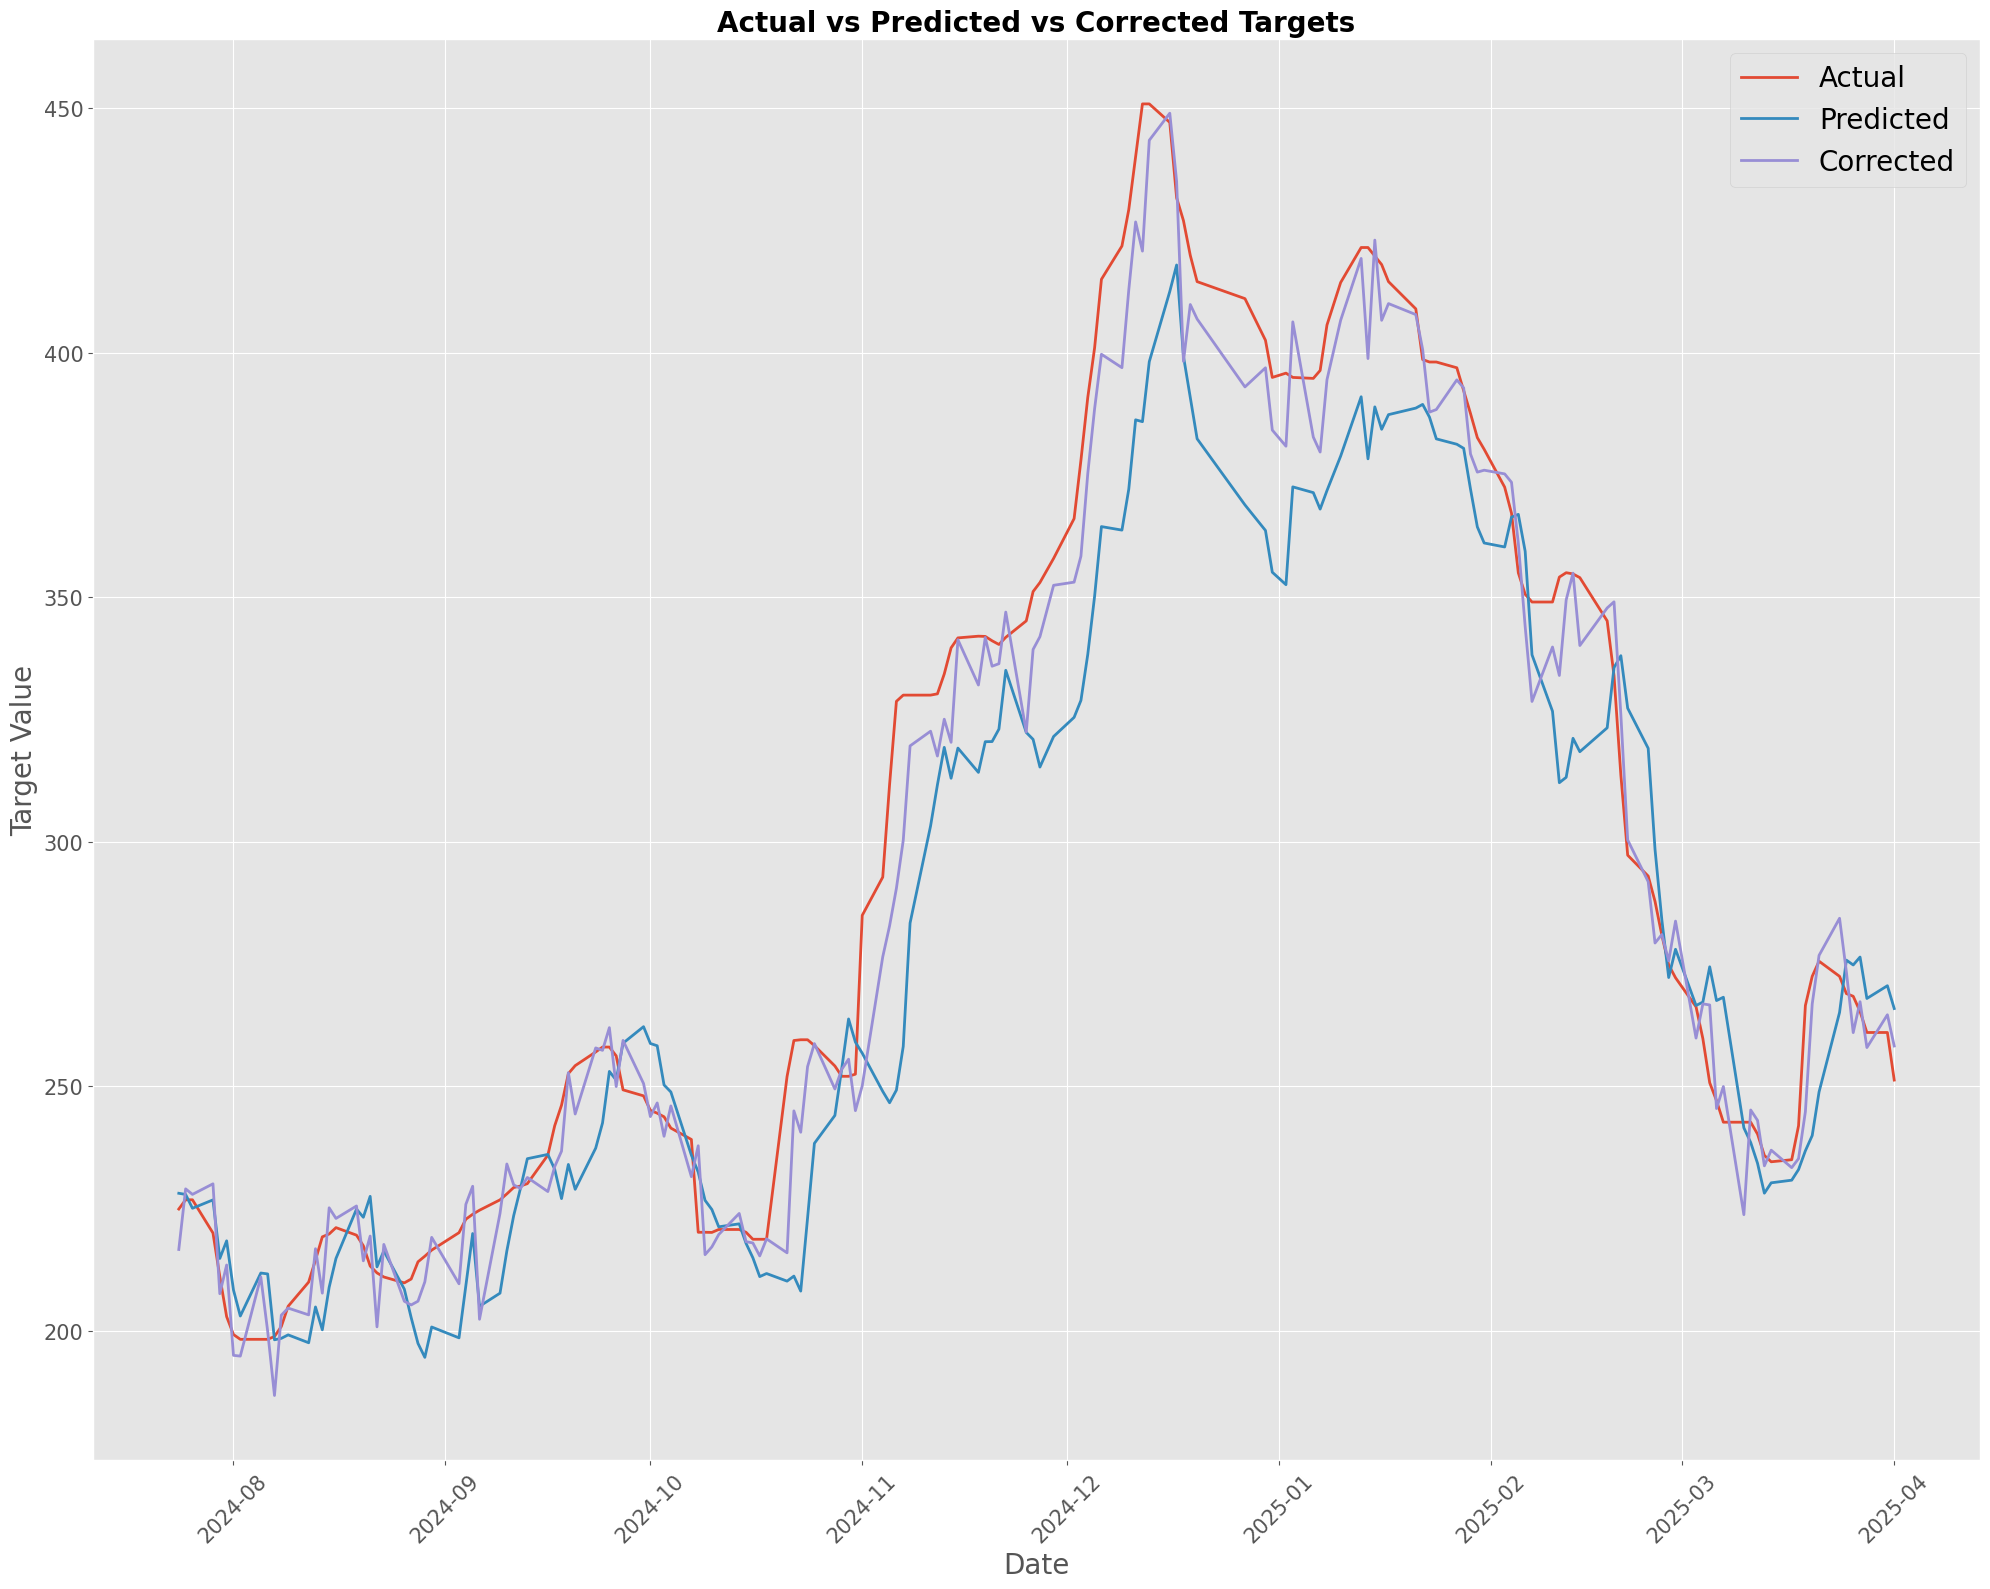

In [62]:
# -------------------------------------------------------------------------------
# 10) Visualizations: Actual vs Predicted vs Corrected
# -------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# Align actuals to the corrected index
actual = corr_df.loc[corr_result.index, 'calculated_targets_MPN5P']
predicted = corr_result['predicted_target']
corrected = corr_result['corrected_target']
dates = corr_result.index

plt.figure(figsize=(20,16))
sns.lineplot(x=dates, y=actual,    label='Actual',    linewidth=2)
sns.lineplot(x=dates, y=predicted, label='Predicted', linewidth=2)
sns.lineplot(x=dates, y=corrected, label='Corrected', linewidth=2)

plt.xlabel('Date', fontsize=20)
plt.ylabel('Target Value', fontsize=20)
plt.title('Actual vs Predicted vs Corrected Targets', fontsize=20, fontweight='bold')
plt.legend(fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

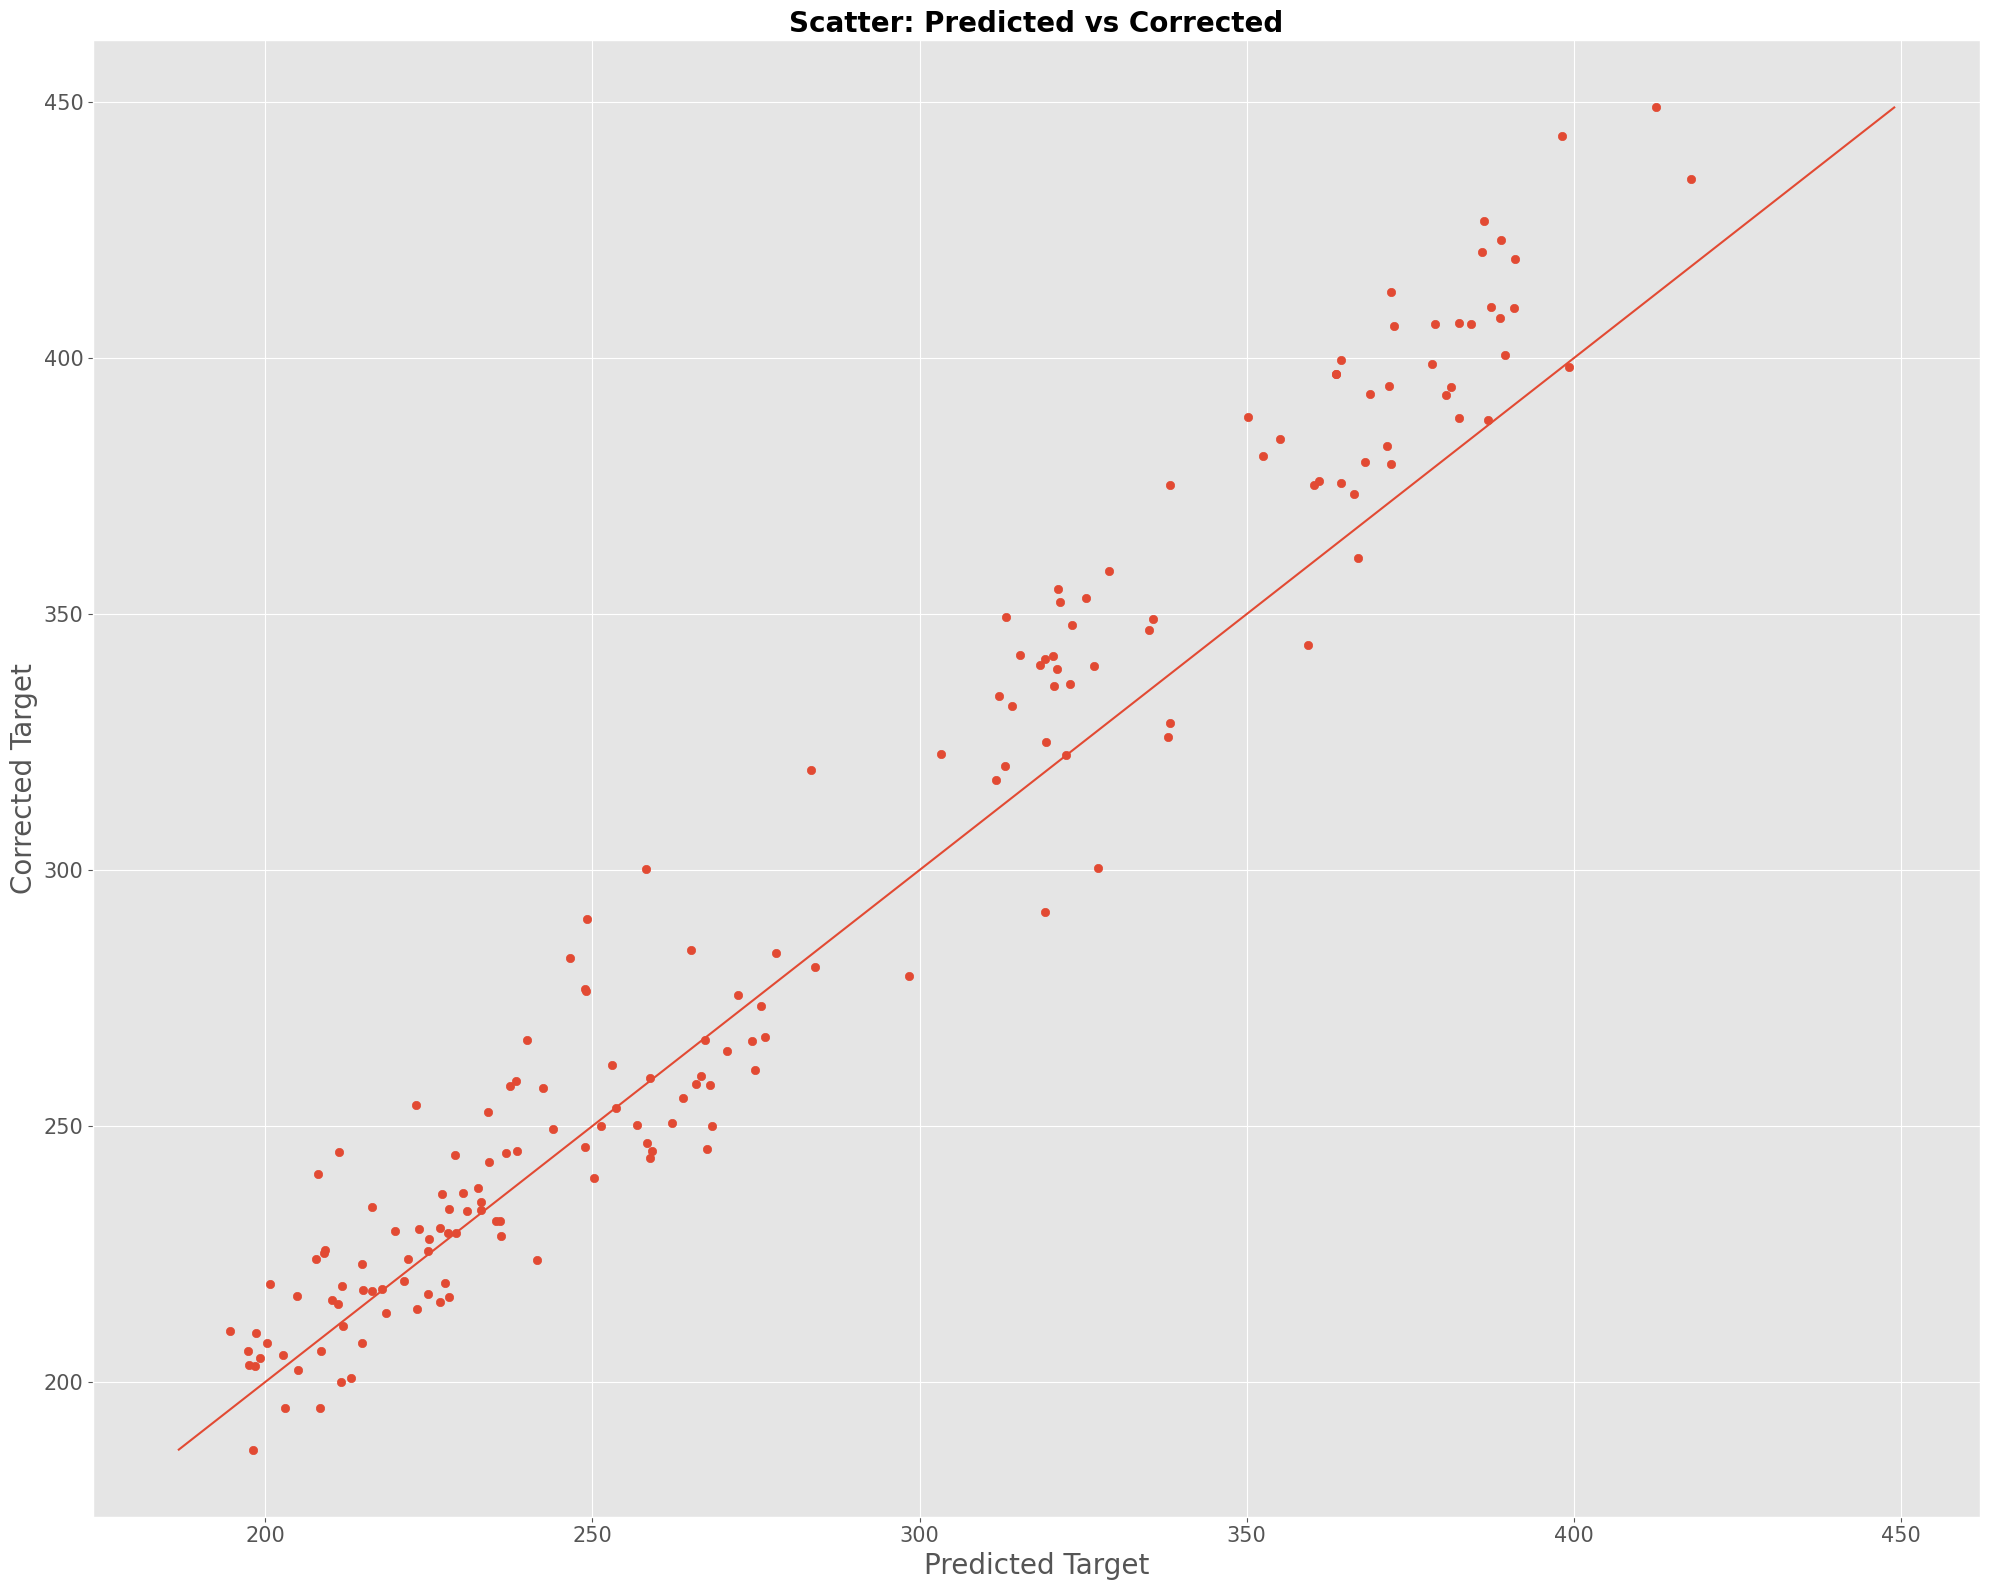

In [63]:
# -------------------------------------------------------------------------------
# 11) Scatter: Predicted vs Corrected 
# -------------------------------------------------------------------------------
plt.figure(figsize=(20,16))

# Scatter points
plt.scatter(predicted, corrected)

# Identity line from (min,min) to (max,max)
min_val = min(predicted.min(), corrected.min())
max_val = max(predicted.max(), corrected.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel('Predicted Target', fontsize=20)
plt.ylabel('Corrected Target', fontsize=20)
plt.title('Scatter: Predicted vs Corrected', fontsize=20, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()
